#1 Business Problem

## 1.1 Problem Statement </h2>

<p>As per the business process, sales team will get requirements from customers and propose the relative content to them, so as to help sales users to also find top similar contents and recommend them. Need to developed recommendation system. Its job is to predict whether customer will show intrest to buy a content based on sales history of conents</p>

## 1.2 Real world/Business Objectives and constraints

1. Predict the probablity that a user would buy a content that he has not yet purchased.
2. No low-latency requirement.


# 2 Machine Learning Problem

## 2.1 Data

### 2.1.1 Data Overview

1. Get the deals data from Rightsline-Deals : https://admin-staging.rightsline.com/

![alt text](./images/legacy_deals.jpg "Rightsline-Deals")

2. Get the content mappings data from Content-API: Mongo-DB Collection
![alt text](./images/content_mapping.jpg "Content-Mapping")

3. Get the high-level data of Series from  Content-API: Mongo-DB Collection
![alt text](./images/series_data.jpg "Series-Data")


## 2.2 Mapping the real world problem to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem

<pre>
For a given user and content we need to predict the probablity that user might buy the content. 
The given problem is a Recommendation problem 
It can also seen as a Classification problem 
</pre>

### 2.2.2 Performance metric

1. Both precision and recall is important so F1 score is good choice: https://en.wikipedia.org/wiki/F-score
2. Confusion Matrix: https://en.wikipedia.org/wiki/Confusion_matrix


### 2.2.3 Machine Learning Objective and Constraints

1. Minimize F1-Score.
2. Try to provide some interpretability.

In [ ]:
# this is just to know how much time will it take to run this entire ipython notebook 

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score


from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix
from collections import Counter
from collections import OrderedDict



drive_path = '/content/drive/MyDrive/poc/data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3 Get Data 

## 3.1 Rightsline Legacy Deals

### 3.1.1 SPS : SPMASALE_TOTAL_STER

<pre>server - WGB01DB7038

select spmasale_dept + spmasale_number as OrderNumber
, AC.spcudtcode +'-'+ ACD.SPCUADACNO as user_act_id, AE.PRMAPROGGENRE_TYPE + '-' + AE.PRMAPROGCAT AS item_genre_id, ACD.SPCUADACNO as account_no, AE.prmaprog_id as item,
sps_spmasale.SPMASALE_TOTAL_STER,
sps_spmasale.spmasale_confdate as ConfirmedDate
from sps_spmasale left outer join sps_spmaline on spmasale_dept = spmaline_dept and spmasale_number = spmaline_sale
left outer join sps_PRmaprog AE on spmaline_progid = AE.prmaprog_id
left outer join sps_spmacudt AC on spcudtcode = spmasale_custno
left outer join sps_spmacuad ACD on spcuadcust = spcudtcode and spmasale_accno = spcuadacno
where 
spmasale_stat_group = 'C'
and spmasale_confdate >= '70000' 
and spmasale_confdate <= '80739' 
</pre>

In [ ]:
# load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
sps_file_path = drive_path+'/raw_data/sps_total_ster_amount_20-04-21.csv'
def load_sps_data(sps_file_path):
  sps_data = pd.read_csv(sps_file_path, names = ['orderNumber', 'SPMASALE_TOTAL_STER'],
                            sep=',', encoding='ISO-8859-1')
  sps_data.orderNumber = sps_data.orderNumber.apply(lambda s: s.replace('ï»¿',''))

  print(sps_data.shape)
  return sps_data
#sps_data = load_sps_data(sps_file_path)

### 3.1.2 Rightsline Legacy Deals


<pre>server - WGB01DB6050

SELECT t1.Deal_ID deal_id, t1.sps_id sps_id, t2.CONTACT_ID [user_id], t4.CATALOG_ID [item_id], t5.Catalog_TEMPLATE
FROM Deal t1
join Deal_LINK_Contact t2 on t2.PARENT_Deal_ID=t1.Deal_ID
join Contact t3 on t2.CONTACT_ID=t3.Contact_ID
join Deal_LINK_Table_Catalog t4 on t4.PARENT_Deal_ID=t1.Deal_ID
join [Catalog] t5 on t5.CATALOG_ID=t4.Catalog_ID
where t1.Deal_TEMPLATE='Legacy Deal'
AND t1.Deal_STATUS='Approved'
AND t2.PTY_LBL='LICENSEE'
AND t3.Contact_STATUS='Active'

</pre>

In [ ]:
# load the legacy deals data of rightsline 
legacy_deals_file_path = drive_path+'/raw_data/legacy_deal_details_20-05-21.csv'
def load_legacy_deals_data(legacy_deals_file_path):

  legacy_deals = pd.read_csv(legacy_deals_file_path,
                            names = ['deal_id', 'sps_id', 'user_id', 'country', 'item_id', 'item_type'],
                            sep=',', encoding='ISO-8859-1')

  legacy_deals.deal_id = legacy_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))
  legacy_deals.drop('country', axis=1, inplace=True)
  legacy_deals.drop_duplicates(inplace=True)

  legacy_deals.sps_id.fillna('NaN', inplace=True)

  print(legacy_deals.shape)
  return legacy_deals
#legacy_deals = load_legacy_deals_data(legacy_deals_file_path)


### 3.1.3 Map the "total_ster_amount_dict" to "legacy_deals" data

In [ ]:
# map the total_ster_amount_dict to legacy_deals data

def map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data):

  count_of_sps_ids = Counter(legacy_deals.sps_id.values)
  total_ster_amount_dict = {i[0]:i[1] for i in sps_data[['orderNumber', 'SPMASALE_TOTAL_STER']].values}

  total_ster_amount = {}
  sps_orderNumbers = sps_data.orderNumber.unique()

  for sps_id in tqdm(legacy_deals.sps_id.unique()):
      sps_ids = sps_id.split('|')
      amounts = []
      for id in sps_ids:
          if id in sps_orderNumbers:
              amounts.append(total_ster_amount_dict[id])
          else:
              amounts.append(np.NAN)
      total_ster_amount[sps_id]=np.sum(amounts)

  legacy_deals['total_ster_amount'] = legacy_deals.sps_id.apply(lambda id: total_ster_amount[id]/count_of_sps_ids[id])
      
  legacy_deals.drop(['sps_id'],axis=1,inplace=True)

  legacy_deals = legacy_deals[['deal_id', 'user_id', 'item_id', 'total_ster_amount', 'item_type']]
  legacy_deals.columns = ['deal_id', 'user_id', 'item_id', 'total_stering_amount', 'item_type']

  print(legacy_deals.shape)
  return legacy_deals
#legacy_deals = map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals)

## 3.2 Rightsline New Deals

<pre>
sever - WGB01DB6050

#### to get rightsline new deals

SELECT t1.Deal_ID deal_id, t2.CONTACT_ID [user_id], t6.CATALOG_ID item_id, t5.allocated_amount_report_amt total_stering_amount,
t7.Catalog_TEMPLATE item_type 
FROM Deal t1
join Deal_LINK_Contact t2 on t2.PARENT_Deal_ID=t1.Deal_ID
join Contact t3 on t2.CONTACT_ID=t3.Contact_ID
join deal_link_table t4 on t4.PARENT_Deal_ID=t1.Deal_ID
join [Table] t5 on t5.table_id=t4.table_id
join Deal_LINK_Table_Catalog t6 on t6.table_id=t5.table_id
join [Catalog] t7 on t7.CATALOG_ID=t6.Catalog_ID
where t1.Deal_TEMPLATE not in ('Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only', 'Legacy Deal')
AND t1.Deal_STATUS='Approved'
AND t2.PTY_LBL='LICENSEE'
AND t3.Contact_STATUS='Active'
AND t5.Table_TEMPLATE='Catalogue Allocation'

</pre>

In [ ]:
# load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
new_deals_file_path = drive_path+'/raw_data/rl_other_deals_20-05-21.csv'
def load_new_deals_data(new_deals_file_path):

  new_deals = pd.read_csv(new_deals_file_path, 
                          names = ['deal_id', 'user_id', 'item_id', 'country', 'total_stering_amount', 'item_type'],
                          
                          sep=',', encoding='ISO-8859-1')

  new_deals.deal_id = new_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))

  new_deals.drop('country',axis=1,inplace=True)

  print(new_deals.shape)
  return new_deals
#new_deals = load_new_deals_data(new_deals_file_path)

## 3.3 Merge both Legacy and New rightsline deals

In [ ]:
all_deals_data = pd.concat([new_deals, legacy_deals])
print(all_deals_data.shape)
print(all_deals_data.head())

(803557, 5)
  deal_id  user_id  item_id  total_stering_amount          item_type
0   72588  1114158   317842                801.93    Episode Version
1   72588  1114158   317843                801.93    Episode Version
2   72588  1114158   317844                801.93    Episode Version
3   72604  1112677   352356             200850.00  Series Collection
4   72621  1112314   350160               6358.02  Series Collection


### 3.3.1 Sales by content type

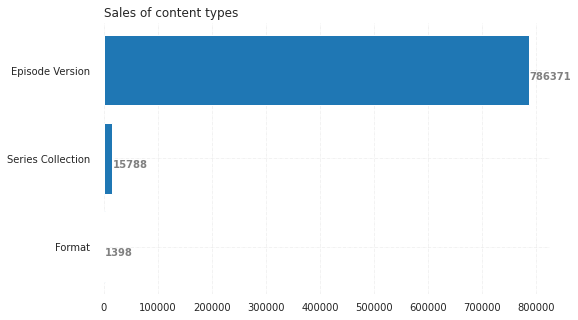

In [ ]:
%matplotlib inline
name = all_deals_data.item_type.value_counts().index
price = all_deals_data.item_type.value_counts().values
  
# Figure Size
fig, ax = plt.subplots(figsize=(8, 5))
  
# Horizontal Bar Plot
ax.barh(name, price)
  
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
  
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
  
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
  
# Add x, y gridlines
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
  
# Show top values
ax.invert_yaxis()
  
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
  
#Add Plot Title
ax.set_title('Sales of content types',
             loc='left', )
  
# Show Plot
plt.show()

In [ ]:
# save "all_deals_data" to csv file
all_deals_data.to_csv(drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv',index=False)

In [ ]:
# load the saved "all_deals_data" file for further processing 
all_deals_data = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv')
print(all_deals_data.shape)
all_deals_data.head()


(803557, 5)


deal_id  user_id  item_id  total_stering_amount          item_type
0    72588  1114158   317842                801.93    Episode Version
1    72588  1114158   317843                801.93    Episode Version
2    72588  1114158   317844                801.93    Episode Version
3    72604  1112677   352356             200850.00  Series Collection
4    72621  1112314   350160               6358.02  Series Collection

## 3.4 Group the data by 'user' & 'item'<br/><br/>
    Create new features 'users_total_purchase_count', 'items_total_purchase_count' & 'class_label=1'

In [ ]:
def create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data):

  all_deals_data = all_deals_data.groupby(['user_id','item_id', 'item_type']).agg({'total_stering_amount': 'sum'}).rename(columns={'total_stering_amount': 'total_stering_amount_sum'}).reset_index()

  users_total_purchase_count = Counter(all_deals_data.user_id)
  items_total_purchase_count = Counter(all_deals_data.item_id)

  all_deals_data['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count)
  all_deals_data['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count)
  all_deals_data['class_label'] = 1

  print(all_deals_data.shape)
  return all_deals_data

#all_deals_data = create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data)


## 3.5 Create Dummy Data with Label 0

In [ ]:
dummy_data_file_path = drive_path+'/intermittent_saved_files/dummy_data.pkl'

def create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path):
  
  # load the saved "dummy_data" file for further processing 
  dummy_data = pd.read_pickle(dummy_data_file_path)

  real_data = list(zip(all_deals_data.user_id.values, all_deals_data.item_id.values))+list(dummy_data)

  uids = all_deals_data.user_id.unique()
  iids = all_deals_data.item_id.unique()

  while (len(dummy_data)<all_deals_data.shape[0]):
      uid = uids[random.randint(0, len(uids)-1)]
      iid = iids[random.randint(0, len(iids)-1)]
      if not (uid, iid) in real_data:
          dummy_data.add((uid,iid))
      else:
          continue
  
  return dummy_data

#dummy_data = create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path)

In [ ]:
# save "dummy_data" to pkl file
pd.to_pickle(dummy_data, drive_path+'/intermittent_saved_files/dummy_data.pkl')

In [ ]:
def create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data):

  item_type_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.item_type.values)))}
  users_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.user_id.values, all_deals_data.users_total_purchase_count.values)))}
  items_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.items_total_purchase_count.values)))}

  dummy_data_with_0_label = pd.DataFrame(data=dummy_data, columns=['user_id','item_id'])
  dummy_data_with_0_label['item_type'] = all_deals_data.item_id.map(item_type_mapping)
  dummy_data_with_0_label['total_stering_amount_sum'] = 0.0
  dummy_data_with_0_label['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count_mapping)
  dummy_data_with_0_label['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count_mapping)
  dummy_data_with_0_label['class_label'] = 0

  print(dummy_data_with_0_label.shape)
  return dummy_data_with_0_label

#dummy_data_with_0_label = create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data)


### 3.5.1 Concatenate Label "1"(real data) and "0"(dummy data) records

In [ ]:
concatenated_data = pd.concat([all_deals_data, dummy_data_with_0_label])
print(concatenated_data.shape)
print(concatenated_data.head())

(1260204, 7)
   user_id  item_id  ... items_total_purchase_count  class_label
0  1111446   163917  ...                         14            1
1  1111446   163920  ...                         35            1
2  1111446   163921  ...                         35            1
3  1111446   166918  ...                         20            1
4  1111446   166986  ...                          5            1

[5 rows x 7 columns]


In [ ]:
# save "concatenated_data" to csv file
concatenated_data.to_csv(drive_path+'/intermittent_saved_files/concatenated_data.csv',index=False)

In [ ]:
# load the saved "concatenated_data" file for further processing 
concatenated_data = pd.read_csv(drive_path+'/intermittent_saved_files/concatenated_data.csv')
print(concatenated_data.shape)
concatenated_data.head()


(1260201, 7)


user_id  item_id  ... items_total_purchase_count  class_label
0  1111446   163917  ...                         14            1
1  1111446   163920  ...                         35            1
2  1111446   163921  ...                         35            1
3  1111446   166918  ...                         20            1
4  1111446   166986  ...                          5            1

[5 rows x 7 columns]

## 3.6 Content Mappings 

<pre>

sever - WGB01DB6050

# to get the catalog_link parent child relationship

SELECT t1.PARENT_Catalog_ID, t2.Catalog_TEMPLATE parent_catalog, t1.CATALOG_ID, t3.Catalog_TEMPLATE child_catalog
  FROM Catalog_LINK_Catalog t1
  join [Catalog] t2
  on t1.PARENT_Catalog_ID=t2.CATALOG_ID
  join [Catalog] t3
  on t1.CATALOG_ID=t3.CATALOG_ID

</pre>

In [ ]:
all_catalog_file_path = drive_path+'/raw_data/Catalog_LINK_Catalog.csv'

def load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path):
  
  all_catalog = pd.read_csv(all_catalog_file_path, encoding='ISO-8859-1', names=['series_id','series_temp','child_1','child_1_temp', 'child_2','child_2_temp', 'child_3','child_3_temp'])
  all_catalog.series_id = all_catalog.series_id.apply(lambda s: str(s).replace('ï»¿',''))
  print(all_catalog.shape)

  s1 = set(zip(all_catalog['child_1_temp'], all_catalog['child_1'], all_catalog['series_id']))
  s2 = set(zip(all_catalog['child_2_temp'], all_catalog['child_2'], all_catalog['series_id']))
  s3 = set(zip(all_catalog['child_3_temp'], all_catalog['child_3'], all_catalog['series_id']))

  s_all = set.union(s1,s2,s3)
  all_contents_mapped_to_series_data = pd.DataFrame(s_all,columns=['content_type', 'content_id', 'series_id'])
  all_contents_mapped_to_series_data = all_contents_mapped_to_series_data[~all_contents_mapped_to_series_data.content_type.isna()]
  all_contents_mapped_to_series_data[['content_id', 'series_id']]=all_contents_mapped_to_series_data[['content_id', 'series_id']].astype(int)
  print(all_contents_mapped_to_series_data.shape)
  print(all_contents_mapped_to_series_data.head())
  
  all_contents_mapped_to_series_data.drop_duplicates(inplace=True)

  return all_contents_mapped_to_series_data

#all_contents_mapped_to_series_data = load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path)

In [ ]:
# save "all_contents_mapped_to_series_data" to csv file
all_contents_mapped_to_series_data.to_csv(drive_path+'/intermittent_saved_files/all_contents_mapped_to_series_data.csv', index=False)

In [ ]:
all_contents_mapped_to_series_data = pd.read_csv(drive_path+'/intermittent_saved_files/all_contents_mapped_to_series_data.csv')
print(all_contents_mapped_to_series_data.shape)
all_contents_mapped_to_series_data.head()

(353559, 3)


content_type  content_id  series_id
0    Episode Version      206896      12290
1    Episode Version      250814      19258
2  Series Collection      323730      13630
3    Episode Version      226337      15930
4    Episode Version      315681      22406

In [ ]:
print("Series Collection: ",all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Series Collection']['content_id'].nunique())
print("Episode Version: ",all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Episode Version']['content_id'].nunique())
print("Series: ",all_contents_mapped_to_series_data['series_id'].nunique())

Series Collection:  33353
Episode Version:  171088
Series:  20889


### 3.6.1 Map the "concatenated_data" data with series_id 

In [ ]:
all_deals_with_series_id = concatenated_data.merge(all_contents_mapped_to_series_data, left_on='item_id', right_on='content_id')
all_deals_with_series_id.drop(['content_type','content_id'],axis=1, inplace=True)
all_deals_with_series_id.drop_duplicates(inplace=True)
print(all_deals_with_series_id.shape)
all_deals_with_series_id.head()


(1258739, 8)


user_id  item_id  ... class_label  series_id
0  1111446   163917  ...           1       6222
1  1112213   163917  ...           1       6222
2  1112349   163917  ...           1       6222
3  1112351   163917  ...           1       6222
4  1112397   163917  ...           1       6222

[5 rows x 8 columns]

### 3.6.2 Map the "concatenated_data" data with "version_creation_type_language" 

<pre> Add 'Version Creation Type', 'Original Language', 'Version Language'

Export the data from Rightsline-Stage

</pre>	


In [ ]:
version_creation_type_language_file_path = drive_path+'/raw_data/version_creation_type_language.csv'
def map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id):
  
  version_creation_type_language = pd.read_csv(version_creation_type_language_file_path)

  all_deals_with_series_id = all_deals_with_series_id.merge(version_creation_type_language, left_on='item_id', right_on='_id')
  all_deals_with_series_id.drop('_id',axis=1,inplace=True)

  print(all_deals_with_series_id.shape)
  return all_deals_with_series_id, version_creation_type_language

#all_deals_with_series_id, version_creation_type_language = map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id)


In [ ]:
# save "all_deals_with_series_id" to csv file
all_deals_with_series_id.to_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv',index=False)

In [ ]:
# load the saved "all_deals_with_series_id" file for further processing 
all_deals_with_series_id = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv')
all_deals_with_series_id[['item_type']]=all_deals_with_series_id[['item_type']].convert_dtypes()
print(all_deals_with_series_id.shape)
all_deals_with_series_id.head()


(1228069, 10)


user_id  item_id  ... version_creation_type  version_language
0  1111446   163917  ...             Worldwide           English
1  1112213   163917  ...             Worldwide           English
2  1112349   163917  ...             Worldwide           English
3  1112351   163917  ...             Worldwide           English
4  1112397   163917  ...             Worldwide           English

[5 rows x 10 columns]

## 3.7 High level data of Series & Customers

### 3.7.1 To create New/Update Series data using Collection

In [ ]:
#https://stackoverflow.com/questions/51359783/python-flatten-multilevel-nested-json

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


In [ ]:
series_file_path = drive_path+'/raw_data/series.json'
def create_series_df(series_file_path):

  import json

  # Opening JSON file
  f = open(series_file_path)
    
  # returns JSON object as 
  # a dictionary
  data = json.load(f)

  out_data = []  
  # Iterating through the json
  # list
  for i in tqdm(data):
    out_data.append(flatten_json(i))
    
  # Closing file
  f.close()

  #create dataframe
  series_df = pd.DataFrame.from_dict(out_data)

  # create the formatted data
  print('Orginal shape')
  print(series_df.shape)
  print(' ')

  for i in range(223):
      firstName = series_df['ContentContributions_Data_{0}_Contributor_Data_FirstName'.format(i)]
      lastName = series_df['ContentContributions_Data_{0}_Contributor_Data_LastName'.format(i)]
      series_df['content_contributor_{0}'.format(i)]=firstName+' '+lastName
              
  print('After combining First & Last Names shape')
  print(series_df.shape)
  print(' ')

  ContentContributions_cols = [col for col in series_df.columns if 'ContentContributions' in col]
  series_df.drop(ContentContributions_cols,axis=1,inplace=True)

  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50', 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data = series_df[series_df.Status=='Approved'][use_columns]
  
  print('After dropping Non-Approved rows & ContentContributions columns')
  print(rl_series_data.shape)

  bool_feat = ['RightsArchive', 'CoreCatalogue', 'PremiumContent', 'VersionAnomaly']
  int_feat = ['_id', 'SequenceNumber', 'CopyrightYear', 'TxYear']
  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']
  drop_features = ['content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data.drop(drop_features,axis=1,inplace=True)

  cat_feat = list(set(use_columns)-set(bool_feat)-set(int_feat))

  rl_series_data[cat_feat] = rl_series_data[cat_feat].astype(str)
  rl_series_data[int_feat] = rl_series_data[int_feat].astype(float)
  rl_series_data[bool_feat] = rl_series_data[bool_feat].astype(bool)
  rl_series_data._id = rl_series_data._id.astype(int)

  return rl_series_data

#rl_series_data = create_series_df(series_file_path)

# save rl_series_data
#rl_series_data.to_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', index=False)

#rl_series_data.head()


In [ ]:
#to check data types within a column with multiple types ?
#https://stackoverflow.com/questions/57882212/how-to-check-data-types-within-a-column-with-multiple-types-looking-for-bette

rl_series_data.applymap(type).apply(pd.value_counts).fillna(0)

_id  ...  content_contributor_50
<class 'int'>    20549.0  ...                     0.0
<class 'str'>        0.0  ...                 20549.0
<class 'bool'>       0.0  ...                     0.0
<class 'float'>      0.0  ...                     0.0

[4 rows x 118 columns]

### 3.7.1.2 Map content_contributors series data to "all_deals_with_series_id"

In [ ]:
rl_series_data_file_path = drive_path+'/intermittent_saved_files/rl_series_data.csv'

def map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id):

  content_contributor_features = ['content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']#, 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']
  rl_content_contributors_data = pd.read_csv(rl_series_data_file_path, usecols=['_id', 'Genres_0_Name']+content_contributor_features) 
  print(rl_content_contributors_data.shape)

  for c in tqdm(content_contributor_features):
    rl_content_contributors_data[c] = rl_content_contributors_data['Genres_0_Name']+" :: "+rl_content_contributors_data[c]
  
  all_deals_with_content_contributors_data = all_deals_with_series_id[all_deals_with_series_id.class_label==1].merge(rl_content_contributors_data, left_on='series_id', right_on='_id')

  all_deals_with_content_contributors_data.drop(['Genres_0_Name', 'series_id', '_id', 'item_id', 'version_language', 'item_type', 'total_stering_amount_sum', 'users_total_purchase_count', 'items_total_purchase_count', 'class_label', 'version_creation_type'], axis=1, inplace=True)

  print(all_deals_with_content_contributors_data.shape)
  
  return all_deals_with_content_contributors_data, content_contributor_features

#all_deals_with_content_contributors_data, content_contributor_features = map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id)
  
#all_deals_with_content_contributors_data.head()


In [ ]:
def create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features):

  all_unique_contrib = all_deals_with_content_contributors_data[content_contributor_features].values.flatten()
  all_unique_contrib_dict = dict(pd.Series(all_unique_contrib).value_counts())

  all_users_contrib_data = {}

  for uid in tqdm(all_deals_with_content_contributors_data['user_id'].unique()):
    all_contrib = all_deals_with_content_contributors_data[all_deals_with_content_contributors_data.user_id==uid][content_contributor_features].values.flatten()
    all_users_contrib_data[uid] = dict(pd.Series(all_contrib).value_counts())

  user_contributor_interaction_sparse_matrix = {}

  user_contributor_interaction_sparse_matrix = csr_matrix((len(all_unique_contrib_dict), all_deals_with_content_contributors_data.user_id.nunique()), dtype=np.uint8)

  user_index_map = {user: idx for idx, user in enumerate(all_deals_with_content_contributors_data.user_id.unique())}
  contrib_index_map = {contrib: idx for idx, contrib in enumerate(all_unique_contrib_dict.keys())}

  for user, contrib_data in tqdm(all_users_contrib_data.items()):
    for contrib, count in contrib_data.items():
      row = contrib_index_map[contrib]
      col = user_index_map[user]
      user_contributor_interaction_sparse_matrix[row, col]=count
  
  return user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix

#user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix = create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features)

In [ ]:
# save user_index_map
pd.to_pickle(user_index_map, drive_path+'/production_data/user_index_map.pkl')

# save contrib_index_map
pd.to_pickle(contrib_index_map, drive_path+'/production_data/contrib_index_map.pkl')

# save user_contributor_interaction_sparse_matrix
pd.to_pickle(user_contributor_interaction_sparse_matrix, drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')


### 3.7.1.2 Map high level series data to "all_deals_with_series_id"

In [ ]:
all_deals_with_series_data = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id')

all_deals_with_series_data.drop(['series_id','_id'], axis=1, inplace=True)

print(all_deals_with_series_data.shape)

all_deals_with_series_data.head()

(1228072, 126)


user_id  item_id  ... content_contributor_49  content_contributor_50
0  1111446   163917  ...                    nan                     nan
1  1112213   163917  ...                    nan                     nan
2  1112349   163917  ...                    nan                     nan
3  1112351   163917  ...                    nan                     nan
4  1112397   163917  ...                    nan                     nan

[5 rows x 126 columns]

### 3.7.2 High level Customer Data

In [ ]:
cusotmer_data_path = drive_path+'/raw_data/customer_data.csv'
def load_customer_data(cusotmer_data_path):

  customer_df = pd.read_csv(cusotmer_data_path, sep=',', encoding='ISO-8859-1')

  customer_df.proforma_customer.fillna(False, inplace=True)
  customer_df.fillna('NaN', inplace=True)

  customer_df.drop(['sap_cstomer_number','contact_name'],axis=1,inplace=True)

  print(customer_df.shape)
  return customer_df

#customer_df = load_customer_data(cusotmer_data_path)

#customer_df.head()


In [ ]:
customer_df[customer_df.customer_language=='NaN']

user_id customer_group  ... customer_language customer_risk_class
45    1114881            NaN  ...               NaN                 NaN
386   1704521     BBCVARIOUS  ...               NaN                 NaN
554   1217953            NaN  ...               NaN                 NaN
869   1114697            NaN  ...               NaN                 NaN
1121  1113385            NaN  ...               NaN                 NaN
2544  1217340            NaN  ...               NaN                 NaN

[6 rows x 8 columns]

In [ ]:
#to check data types within a column with multiple types ?
#https://stackoverflow.com/questions/57882212/how-to-check-data-types-within-a-column-with-multiple-types-looking-for-bette

customer_df.applymap(type).apply(pd.value_counts).fillna(0)

user_id  customer_group  ...  customer_language  customer_risk_class
<class 'int'>    3666.0             0.0  ...                0.0                  0.0
<class 'str'>       0.0          3666.0  ...             3666.0               3666.0
<class 'bool'>      0.0             0.0  ...                0.0                  0.0

[3 rows x 8 columns]

### 3.7.2.1 Map the customer data to "all_deals_with_series_data"

In [ ]:
all_deals_with_series_customer_data = all_deals_with_series_data.merge(customer_df, on='user_id')
all_deals_with_series_customer_data.drop_duplicates(inplace=True)

print(all_deals_with_series_customer_data.shape)
all_deals_with_series_customer_data.head()

(1228072, 133)


user_id  item_id  ... customer_language  customer_risk_class
0  1111446   163917  ...                EN                    C
1  1111446   163920  ...                EN                    C
2  1111446   163921  ...                EN                    C
3  1111446   166918  ...                EN                    C
4  1111446   166986  ...                EN                    C

[5 rows x 133 columns]

In [ ]:
# # save "all_deals_with_series_customer_data" to csv file
# all_deals_with_series_customer_data.to_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_customer_data.csv',index=False)

In [ ]:
# # # load the saved "all_deals_with_series_customer_data" file for further processing 
# all_deals_with_series_customer_data = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_customer_data.csv', dtype=dtypes)
# print(all_deals_with_series_customer_data.shape)
# all_deals_with_series_customer_data.head()


In [ ]:
all_deals_with_series_customer_data.applymap(type).apply(pd.value_counts).fillna(0)

user_id    item_id  ...  customer_language  customer_risk_class
<class 'int'>    1228069.0  1228069.0  ...                0.0                  0.0
<class 'str'>          0.0        0.0  ...          1228069.0            1228069.0
<class 'float'>        0.0        0.0  ...                0.0                  0.0
<class 'bool'>         0.0        0.0  ...                0.0                  0.0

[4 rows x 133 columns]

###3.7.2 Map series data to SeriesCollections

In [ ]:
seriesCollection_file_path = drive_path+'/raw_data/seriesCollection.csv'

def create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data):

  all_seriesCollections_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Series Collection'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_seriesCollections_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  seriesCollection_title = pd.read_csv(seriesCollection_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  seriesCollection_title.dropna(inplace=True)
  seriesCollection_title.RecordID = seriesCollection_title.RecordID.astype(int)

  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_seriesCollections_with_series_data.drop('_id',axis=1,inplace=True)
  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(seriesCollection_title, left_on='content_id', right_on='RecordID')
  #all_seriesCollections_with_series_data.drop_duplicates(inplace=True)
  all_seriesCollections_with_series_data['title_without_version_creation_type'] = all_seriesCollections_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  #all_seriesCollections_with_series_data['duplicate_count'] = all_seriesCollections_with_series_data['title_without_version_creation_type'].map(Counter(all_seriesCollections_with_series_data['title_without_version_creation_type']))
  all_seriesCollections_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_seriesCollections_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'] ,axis=1,inplace=True)

  print(all_seriesCollections_with_series_data.shape)
  return all_seriesCollections_with_series_data

#all_seriesCollections_with_series_data = create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path)

#all_seriesCollections_with_series_data.head()

In [ ]:
# save "all_seriesCollections_with_series_data" to csv file
all_seriesCollections_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_seriesCollections_with_series_data.csv',index=False)

In [ ]:
all_seriesCollections_with_series_data.applymap(type).apply(pd.value_counts).fillna(0)

content_id  ...  version_language
<class 'int'>       25440.0  ...               0.0
<class 'str'>           0.0  ...           25440.0
<class 'bool'>          0.0  ...               0.0
<class 'float'>         0.0  ...               0.0

[4 rows x 120 columns]

###3.7.3 Map series data to EpisodeVersions

In [ ]:
episodeVersion_file_path = drive_path+'/raw_data/episodeVersion.csv'

def create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data):

  all_episodeVersions_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Episode Version'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_episodeVersions_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  all_episodeVersions_with_series_data.drop_duplicates(inplace=True)

  episodeVersion_title = pd.read_csv(episodeVersion_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  episodeVersion_title.dropna(inplace=True)
  episodeVersion_title.RecordID = episodeVersion_title.RecordID.astype(int)

  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_episodeVersions_with_series_data.drop('_id',axis=1,inplace=True)
  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(episodeVersion_title, left_on='content_id', right_on='RecordID')
  all_episodeVersions_with_series_data['title_without_version_creation_type'] = all_episodeVersions_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  all_episodeVersions_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_episodeVersions_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'],axis=1,inplace=True)

  print(all_episodeVersions_with_series_data.shape)
  return all_episodeVersions_with_series_data

#all_episodeVersions_with_series_data = create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path)

#all_episodeVersions_with_series_data.head()

In [ ]:
# save "all_episodeVersions_with_series_data" to csv file
all_episodeVersions_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_episodeVersions_with_series_data.csv',index=False)

In [ ]:
all_episodeVersions_with_series_data.applymap(type).apply(pd.value_counts).fillna(0)

content_id  ...  version_language
<class 'int'>      142384.0  ...               0.0
<class 'str'>           0.0  ...          142384.0
<class 'bool'>          0.0  ...               0.0
<class 'float'>         0.0  ...               0.0

[4 rows x 120 columns]

#4 Data Preprocessing

## 4.1 Data checks

###4.1.1 Checking for NaN values

In [ ]:
print("# of Nan values in our dataframe : ", sum(all_deals_with_series_customer_data.isnull().any()))

# of Nan values in our dataframe :  3


###4.1.2 Removing Duplicates

In [ ]:
dup_bool = all_deals_with_series_customer_data.duplicated(['user_id','item_id','class_label'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


###4.1.3 Basic Statistics (#Labels, #Users, and #Items)

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of Labels :",all_deals_with_series_customer_data.shape[0])
print("Total No of Users   :", len(np.unique(all_deals_with_series_customer_data.user_id)))
print("Total No of Items  :", len(np.unique(all_deals_with_series_customer_data.item_id)))

Total data 
--------------------------------------------------

Total no of Labels : 1228069
Total No of Users   : 1681
Total No of Items  : 66745


##4.2 Split data into Train and Test(80:20)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_deals_with_series_customer_data, stratify = all_deals_with_series_customer_data['class_label'], test_size=.20)

###4.2.1 Basic Statistics in Train data (#Labels, #Users, and #Items)

In [ ]:
print("Training data ")
print("-"*50)
print("\nTotal no of labels :",train_data.shape[0])
print("Total No of Users   :", len(np.unique(train_data.user_id)))
print("Total No of items  :", len(np.unique(train_data.item_id)))

Training data 
--------------------------------------------------

Total no of labels : 982457
Total No of Users   : 1681
Total No of items  : 66739


###4.2.2 Basic Statistics in Test data (#Labels, #Users, and #Items)

In [ ]:
print("Test data ")
print("-"*50)
print("\nTotal no of labels :",test_data.shape[0])
print("Total No of Users   :", len(np.unique(test_data.user_id)))
print("Total No of Items  :", len(np.unique(test_data.item_id)))

Test data 
--------------------------------------------------

Total no of labels : 245615
Total No of Users   : 1680
Total No of Items  : 61963


##4.3 Handling Categorical Features

In [ ]:
from sklearn.preprocessing import LabelEncoder

def vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data):

  categoical_fetaures = [feat for feat in  train_data.columns if type(train_data[feat].iloc[0])==str]
  encode_objects_name = ["{0}_encode".format(col) for col in categoical_fetaures]

  for idx, feat in tqdm(enumerate(categoical_fetaures)):
      encode_objects_name[idx] = LabelEncoder()
      encode_objects_name[idx].fit(train_data[feat])

      #https://stackoverflow.com/questions/40321232/handling-unknown-values-for-label-encoding
      diff = [i for i in test_data[feat].unique() if i not in encode_objects_name[idx].classes_]
      if len(diff)>0:
          test_data[feat] = test_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
          encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
      train_data[feat]=encode_objects_name[idx].transform(train_data[feat])
      test_data[feat]=encode_objects_name[idx].transform(test_data[feat])

      if feat not in ['item_type', 'customer_group',
        'customer_city', 'customer_country', 'customer_active_salesorg',
        'customer_language', 'customer_risk_class']:
        sc_diff = [i for i in all_seriesCollections_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(sc_diff)>0:
            all_seriesCollections_with_series_data[feat] = all_seriesCollections_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_seriesCollections_with_series_data[feat]=encode_objects_name[idx].transform(all_seriesCollections_with_series_data[feat])

        epv_diff = [i for i in all_episodeVersions_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(epv_diff)>0:
            all_episodeVersions_with_series_data[feat] = all_episodeVersions_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_episodeVersions_with_series_data[feat]=encode_objects_name[idx].transform(all_episodeVersions_with_series_data[feat])
    
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

#train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data)

##4.4 Handling Numerical Features

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data):

  numerical_fetaures = [feat for feat in  all_deals_with_series_data.columns 
                        if (type(all_deals_with_series_data[feat].iloc[0])!=str) & (feat not in ['user_id','item_id','class_label'])]
  scaler_objects_name = ["{0}_scaler".format(col) for col in numerical_fetaures]

  mean_imp_objects_name = ["{0}_mean_imp".format(col) for col in numerical_fetaures]

  for idx, feat in enumerate(numerical_fetaures):

      #Imputation of missing values
      mean_imp_objects_name[idx] = SimpleImputer(missing_values=np.nan, strategy='mean')
      mean_imp_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat] = mean_imp_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1))
      test_data[feat] = mean_imp_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1))

      # Standardization of numerical values
      scaler_objects_name[idx] = StandardScaler()
      scaler_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat]=scaler_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1) )
      test_data[feat]=scaler_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1) )

      if feat not in ['items_total_purchase_count', 'total_stering_amount_sum', 'users_total_purchase_count']:
        all_episodeVersions_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1))
        all_episodeVersions_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1) )

        all_seriesCollections_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1))
        all_seriesCollections_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1) )
  
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

#train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data)

In [ ]:
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

def get_dtypes(df):
  cols = df.dtypes.index
  col_dtypes = df.dtypes.values

  return {cols[idx]:str(col_dtypes[idx]) for idx in range(len(cols))}


In [ ]:
# reduce the memory size of user_lookup_data
train_data, _ = reduce_mem_usage(train_data)
test_data, _ = reduce_mem_usage(test_data)
all_seriesCollections_with_series_data, _ = reduce_mem_usage(all_seriesCollections_with_series_data)
all_episodeVersions_with_series_data, _ = reduce_mem_usage(all_episodeVersions_with_series_data)

# save "user_lookup_data" dtypes to pkl file
pd.to_pickle(get_dtypes(train_data),drive_path+'/production_data/train_test_df_dtypes.pkl')

In [ ]:
all_seriesCollections_with_series_data['item_type']=2
all_seriesCollections_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
all_seriesCollections_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
all_seriesCollections_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", index=False)

all_episodeVersions_with_series_data['item_type']=0
all_episodeVersions_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
all_episodeVersions_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
all_episodeVersions_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", index=False)

# save "train_data" to csv file
train_data.to_csv(drive_path+'/intermittent_saved_files/train_data.csv',index=False)

# save "test_data" to csv file
test_data.to_csv(drive_path+'/intermittent_saved_files/test_data.csv',index=False)

In [ ]:
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)
all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)
all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)


## Data Pipeline

In [ ]:
# load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
def load_sps_data(sps_file_path):
  sps_data = pd.read_csv(sps_file_path, names = ['orderNumber', 'SPMASALE_TOTAL_STER'],
                            sep=',', encoding='ISO-8859-1')
  sps_data.orderNumber = sps_data.orderNumber.apply(lambda s: s.replace('ï»¿',''))

  print(sps_data.shape)
  return sps_data


# load the legacy deals data of rightsline 
def load_legacy_deals_data(legacy_deals_file_path):

  legacy_deals = pd.read_csv(legacy_deals_file_path,
                            names = ['deal_id', 'sps_id', 'user_id', 'country', 'item_id', 'item_type'],
                            sep=',', encoding='ISO-8859-1')

  legacy_deals.deal_id = legacy_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))
  legacy_deals.drop('country', axis=1, inplace=True)
  legacy_deals.drop_duplicates(inplace=True)

  legacy_deals.sps_id.fillna('NaN', inplace=True)

  print(legacy_deals.shape)
  return legacy_deals


# map the total_ster_amount_dict to legacy_deals data

def map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data):

  count_of_sps_ids = Counter(legacy_deals.sps_id.values)
  total_ster_amount_dict = {i[0]:i[1] for i in sps_data[['orderNumber', 'SPMASALE_TOTAL_STER']].values}

  total_ster_amount = {}
  sps_orderNumbers = sps_data.orderNumber.unique()

  for sps_id in tqdm(legacy_deals.sps_id.unique()):
      sps_ids = sps_id.split('|')
      amounts = []
      for id in sps_ids:
          if id in sps_orderNumbers:
              amounts.append(total_ster_amount_dict[id])
          else:
              amounts.append(np.NAN)
      total_ster_amount[sps_id]=np.sum(amounts)

  legacy_deals['total_ster_amount'] = legacy_deals.sps_id.apply(lambda id: total_ster_amount[id]/count_of_sps_ids[id])
      
  legacy_deals.drop(['sps_id'],axis=1,inplace=True)

  legacy_deals = legacy_deals[['deal_id', 'user_id', 'item_id', 'total_ster_amount', 'item_type']]
  legacy_deals.columns = ['deal_id', 'user_id', 'item_id', 'total_stering_amount', 'item_type']

  print(legacy_deals.shape)
  return legacy_deals

# load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
def load_new_deals_data(new_deals_file_path):

  new_deals = pd.read_csv(new_deals_file_path, 
                          names = ['deal_id', 'user_id', 'item_id', 'country', 'total_stering_amount', 'item_type'],
                          
                          sep=',', encoding='ISO-8859-1')

  new_deals.deal_id = new_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))

  new_deals.drop('country',axis=1,inplace=True)

  print(new_deals.shape)
  return new_deals

def create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data):

  all_deals_data = all_deals_data.groupby(['user_id','item_id', 'item_type']).agg({'total_stering_amount': 'sum'}).rename(columns={'total_stering_amount': 'total_stering_amount_sum'}).reset_index()

  users_total_purchase_count = Counter(all_deals_data.user_id)
  items_total_purchase_count = Counter(all_deals_data.item_id)

  all_deals_data['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count)
  all_deals_data['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count)
  all_deals_data['class_label'] = 1

  print(all_deals_data.shape)
  return all_deals_data

#Create Dummy Data with Label 0

def create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path):
  
  # load the saved "dummy_data" file for further processing 
  dummy_data = pd.read_pickle(dummy_data_file_path)

  real_data = list(zip(all_deals_data.user_id.values, all_deals_data.item_id.values))+list(dummy_data)

  uids = all_deals_data.user_id.unique()
  iids = all_deals_data.item_id.unique()

  while (len(dummy_data)<all_deals_data.shape[0]):
      uid = uids[random.randint(0, len(uids)-1)]
      iid = iids[random.randint(0, len(iids)-1)]
      if not (uid, iid) in real_data:
          dummy_data.add((uid,iid))
      else:
          continue
  
  return dummy_data

def create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data):

  item_type_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.item_type.values)))}
  users_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.user_id.values, all_deals_data.users_total_purchase_count.values)))}
  items_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.items_total_purchase_count.values)))}

  dummy_data_with_0_label = pd.DataFrame(data=dummy_data, columns=['user_id','item_id'])
  dummy_data_with_0_label['item_type'] = all_deals_data.item_id.map(item_type_mapping)
  dummy_data_with_0_label['total_stering_amount_sum'] = 0.0
  dummy_data_with_0_label['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count_mapping)
  dummy_data_with_0_label['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count_mapping)
  dummy_data_with_0_label['class_label'] = 0

  print(dummy_data_with_0_label.shape)
  return dummy_data_with_0_label

# Content Mappings
def load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path):
  
  all_catalog = pd.read_csv(all_catalog_file_path, encoding='ISO-8859-1', names=['series_id','series_temp','child_1','child_1_temp', 'child_2','child_2_temp', 'child_3','child_3_temp'])
  all_catalog.series_id = all_catalog.series_id.apply(lambda s: str(s).replace('ï»¿',''))
  print(all_catalog.shape)

  s1 = set(zip(all_catalog['child_1_temp'], all_catalog['child_1'], all_catalog['series_id']))
  s2 = set(zip(all_catalog['child_2_temp'], all_catalog['child_2'], all_catalog['series_id']))
  s3 = set(zip(all_catalog['child_3_temp'], all_catalog['child_3'], all_catalog['series_id']))

  s_all = set.union(s1,s2,s3)
  all_contents_mapped_to_series_data = pd.DataFrame(s_all,columns=['content_type', 'content_id', 'series_id'])
  all_contents_mapped_to_series_data = all_contents_mapped_to_series_data[~all_contents_mapped_to_series_data.content_type.isna()]
  all_contents_mapped_to_series_data[['content_id', 'series_id']]=all_contents_mapped_to_series_data[['content_id', 'series_id']].astype(int)
  print(all_contents_mapped_to_series_data.shape)
  
  all_contents_mapped_to_series_data.drop_duplicates(inplace=True)

  return all_contents_mapped_to_series_data

# Map the "concatenated_data" data with "version_creation_type_language"

def map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id):
  
  version_creation_type_language = pd.read_csv(version_creation_type_language_file_path)

  all_deals_with_series_id = all_deals_with_series_id.merge(version_creation_type_language, left_on='item_id', right_on='_id')
  all_deals_with_series_id.drop('_id',axis=1,inplace=True)

  print(all_deals_with_series_id.shape)
  return all_deals_with_series_id, version_creation_type_language

# High level data of Series
# To create New/Update Series data using Collection
#https://stackoverflow.com/questions/51359783/python-flatten-multilevel-nested-json

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def create_series_df(series_file_path):

  import json

  # Opening JSON file
  f = open(series_file_path)
    
  # returns JSON object as 
  # a dictionary
  data = json.load(f)

  out_data = []  
  # Iterating through the json
  # list
  for i in tqdm(data):
    out_data.append(flatten_json(i))
    
  # Closing file
  f.close()

  #create dataframe
  series_df = pd.DataFrame.from_dict(out_data)

  # create the formatted data
  print('Orginal shape')
  print(series_df.shape)
  print(' ')

  for i in range(223):
      firstName = series_df['ContentContributions_Data_{0}_Contributor_Data_FirstName'.format(i)]
      lastName = series_df['ContentContributions_Data_{0}_Contributor_Data_LastName'.format(i)]
      series_df['content_contributor_{0}'.format(i)]=firstName+' '+lastName
              
  print('After combining First & Last Names shape')
  print(series_df.shape)
  print(' ')

  ContentContributions_cols = [col for col in series_df.columns if 'ContentContributions' in col]
  series_df.drop(ContentContributions_cols,axis=1,inplace=True)

  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50', 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data = series_df[series_df.Status=='Approved'][use_columns]
  
  print('After dropping Non-Approved rows & ContentContributions columns')
  print(rl_series_data.shape)

  bool_feat = ['RightsArchive', 'CoreCatalogue', 'PremiumContent', 'VersionAnomaly']
  int_feat = ['_id', 'SequenceNumber', 'CopyrightYear', 'TxYear']
  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']
  drop_features = ['content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data.drop(drop_features,axis=1,inplace=True)

  cat_feat = list(set(use_columns)-set(bool_feat)-set(int_feat))

  rl_series_data[cat_feat] = rl_series_data[cat_feat].astype(str)
  rl_series_data[int_feat] = rl_series_data[int_feat].astype(float)
  rl_series_data[bool_feat] = rl_series_data[bool_feat].astype(bool)
  rl_series_data._id = rl_series_data._id.astype(int)

  return rl_series_data

# Map content_contributors series data to "all_deals_with_series_id"

def map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id):

  content_contributor_features = ['content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']#, 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']
  rl_content_contributors_data = pd.read_csv(rl_series_data_file_path, usecols=['_id', 'Genres_0_Name']+content_contributor_features) 
  print(rl_content_contributors_data.shape)

  for c in tqdm(content_contributor_features):
    rl_content_contributors_data[c] = rl_content_contributors_data['Genres_0_Name']+" :: "+rl_content_contributors_data[c]
  
  all_deals_with_content_contributors_data = all_deals_with_series_id[all_deals_with_series_id.class_label==1].merge(rl_content_contributors_data, left_on='series_id', right_on='_id')

  all_deals_with_content_contributors_data.drop(['Genres_0_Name', 'series_id', '_id', 'item_id', 'version_language', 'item_type', 'total_stering_amount_sum', 'users_total_purchase_count', 'items_total_purchase_count', 'class_label', 'version_creation_type'], axis=1, inplace=True)

  print(all_deals_with_content_contributors_data.shape)
  
  return all_deals_with_content_contributors_data, content_contributor_features

def create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features):

  all_unique_contrib = all_deals_with_content_contributors_data[content_contributor_features].values.flatten()
  all_unique_contrib_dict = dict(pd.Series(all_unique_contrib).value_counts())

  all_users_contrib_data = {}

  for uid in tqdm(all_deals_with_content_contributors_data['user_id'].unique()):
    all_contrib = all_deals_with_content_contributors_data[all_deals_with_content_contributors_data.user_id==uid][content_contributor_features].values.flatten()
    all_users_contrib_data[uid] = dict(pd.Series(all_contrib).value_counts())

  user_contributor_interaction_sparse_matrix = {}

  user_contributor_interaction_sparse_matrix = csr_matrix((len(all_unique_contrib_dict), all_deals_with_content_contributors_data.user_id.nunique()), dtype=np.uint8)

  user_index_map = {user: idx for idx, user in enumerate(all_deals_with_content_contributors_data.user_id.unique())}
  contrib_index_map = {contrib: idx for idx, contrib in enumerate(all_unique_contrib_dict.keys())}

  for user, contrib_data in tqdm(all_users_contrib_data.items()):
    for contrib, count in contrib_data.items():
      row = contrib_index_map[contrib]
      col = user_index_map[user]
      user_contributor_interaction_sparse_matrix[row, col]=count
  
  return user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix

# High level Customer Data
def load_customer_data(cusotmer_data_path):

  customer_df = pd.read_csv(cusotmer_data_path, sep=',', encoding='ISO-8859-1')

  customer_df.proforma_customer.fillna(False, inplace=True)
  customer_df.fillna('NaN', inplace=True)

  customer_df.drop(['sap_cstomer_number','contact_name'],axis=1,inplace=True)

  print(customer_df.shape)
  return customer_df

# Map series data to SeriesCollections

def create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data):

  all_seriesCollections_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Series Collection'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_seriesCollections_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  seriesCollection_title = pd.read_csv(seriesCollection_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  seriesCollection_title.dropna(inplace=True)
  seriesCollection_title.RecordID = seriesCollection_title.RecordID.astype(int)

  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_seriesCollections_with_series_data.drop('_id',axis=1,inplace=True)
  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(seriesCollection_title, left_on='content_id', right_on='RecordID')
  #all_seriesCollections_with_series_data.drop_duplicates(inplace=True)
  all_seriesCollections_with_series_data['title_without_version_creation_type'] = all_seriesCollections_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  #all_seriesCollections_with_series_data['duplicate_count'] = all_seriesCollections_with_series_data['title_without_version_creation_type'].map(Counter(all_seriesCollections_with_series_data['title_without_version_creation_type']))
  all_seriesCollections_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_seriesCollections_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'] ,axis=1,inplace=True)

  print(all_seriesCollections_with_series_data.shape)
  return all_seriesCollections_with_series_data

# Map series data to EpisodeVersions

def create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data):

  all_episodeVersions_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Episode Version'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_episodeVersions_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  all_episodeVersions_with_series_data.drop_duplicates(inplace=True)

  episodeVersion_title = pd.read_csv(episodeVersion_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  episodeVersion_title.dropna(inplace=True)
  episodeVersion_title.RecordID = episodeVersion_title.RecordID.astype(int)

  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_episodeVersions_with_series_data.drop('_id',axis=1,inplace=True)
  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(episodeVersion_title, left_on='content_id', right_on='RecordID')
  all_episodeVersions_with_series_data['title_without_version_creation_type'] = all_episodeVersions_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  all_episodeVersions_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_episodeVersions_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'],axis=1,inplace=True)

  print(all_episodeVersions_with_series_data.shape)
  return all_episodeVersions_with_series_data

# Handling Categorical Features

def vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data):

  categoical_fetaures = [feat for feat in  train_data.columns if type(train_data[feat].iloc[0])==str]
  encode_objects_name = ["{0}_encode".format(col) for col in categoical_fetaures]

  for idx, feat in tqdm(enumerate(categoical_fetaures)):
      encode_objects_name[idx] = LabelEncoder()
      encode_objects_name[idx].fit(train_data[feat])

      #https://stackoverflow.com/questions/40321232/handling-unknown-values-for-label-encoding
      diff = [i for i in test_data[feat].unique() if i not in encode_objects_name[idx].classes_]
      if len(diff)>0:
          test_data[feat] = test_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
          encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
      train_data[feat]=encode_objects_name[idx].transform(train_data[feat])
      test_data[feat]=encode_objects_name[idx].transform(test_data[feat])

      if feat not in ['item_type', 'customer_group',
        'customer_city', 'customer_country', 'customer_active_salesorg',
        'customer_language', 'customer_risk_class']:
        sc_diff = [i for i in all_seriesCollections_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(sc_diff)>0:
            all_seriesCollections_with_series_data[feat] = all_seriesCollections_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_seriesCollections_with_series_data[feat]=encode_objects_name[idx].transform(all_seriesCollections_with_series_data[feat])

        epv_diff = [i for i in all_episodeVersions_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(epv_diff)>0:
            all_episodeVersions_with_series_data[feat] = all_episodeVersions_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_episodeVersions_with_series_data[feat]=encode_objects_name[idx].transform(all_episodeVersions_with_series_data[feat])
    
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

# Handling Numerical Features
def impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data):

  numerical_fetaures = [feat for feat in  all_deals_with_series_data.columns 
                        if (type(all_deals_with_series_data[feat].iloc[0])!=str) & (feat not in ['user_id','item_id','class_label'])]
  scaler_objects_name = ["{0}_scaler".format(col) for col in numerical_fetaures]

  mean_imp_objects_name = ["{0}_mean_imp".format(col) for col in numerical_fetaures]

  for idx, feat in enumerate(numerical_fetaures):

      #Imputation of missing values
      mean_imp_objects_name[idx] = SimpleImputer(missing_values=np.nan, strategy='mean')
      mean_imp_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat] = mean_imp_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1))
      test_data[feat] = mean_imp_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1))

      # Standardization of numerical values
      scaler_objects_name[idx] = StandardScaler()
      scaler_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat]=scaler_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1) )
      test_data[feat]=scaler_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1) )

      if feat not in ['items_total_purchase_count', 'total_stering_amount_sum', 'users_total_purchase_count']:
        all_episodeVersions_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1))
        all_episodeVersions_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1) )

        all_seriesCollections_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1))
        all_seriesCollections_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1) )
  
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data
  
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

def get_dtypes(df):
  cols = df.dtypes.index
  col_dtypes = df.dtypes.values

  return {cols[idx]:str(col_dtypes[idx]) for idx in range(len(cols))}


In [ ]:
def content_based_data_pipleline():

  print('load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id')
  sps_file_path = drive_path+'/raw_data/sps_total_ster_amount_20-04-21.csv'
  sps_data = load_sps_data(sps_file_path)

  print('load the legacy deals data of rightsline') 
  legacy_deals_file_path = drive_path+'/raw_data/legacy_deal_details_20-05-21.csv'
  legacy_deals = load_legacy_deals_data(legacy_deals_file_path)

  print('map the total_ster_amount_dict to legacy_deals data')
  legacy_deals = map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data)

  print("load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'")
  new_deals_file_path = drive_path+'/raw_data/rl_other_deals_20-05-21.csv'
  new_deals = load_new_deals_data(new_deals_file_path)

  all_deals_data = pd.concat([new_deals, legacy_deals])
  print(all_deals_data.shape)

  print('save "all_deals_data" to csv file')
  all_deals_data_file_path = drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv'
  all_deals_data.to_csv(all_deals_data_file_path,index=False)

  print('save "all_deals_data" to csv file')
  all_deals_data.to_csv(drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv',index=False)

  print("Create new features 'users_total_purchase_count', 'items_total_purchase_count' & 'class_label=1'")
  all_deals_data = create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data)

  print('Create Dummy Data with Label 0')
  dummy_data_file_path = drive_path+'/intermittent_saved_files/dummy_data.pkl'
  dummy_data = create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path)

  print('save "dummy_data" to pkl file')
  pd.to_pickle(dummy_data, dummy_data_file_path)

  dummy_data_with_0_label = create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data)

  concatenated_data = pd.concat([all_deals_data, dummy_data_with_0_label])
  print(concatenated_data.shape)

  print('save "concatenated_data" to csv file')
  concatenated_data.to_csv(drive_path+'/intermittent_saved_files/concatenated_data.csv',index=False)

  print('content_mapping')
  all_catalog_file_path = drive_path+'/raw_data/Catalog_LINK_Catalog.csv'
  all_contents_mapped_to_series_data = load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path)

  print('save "all_contents_mapped_to_series_data" to csv file')
  all_contents_mapped_to_series_data.to_csv(drive_path+'/intermittent_saved_files/all_contents_mapped_to_series_data.csv', index=False)

  print('Map the "concatenated_data" data with series_id')
  all_deals_with_series_id = concatenated_data.merge(all_contents_mapped_to_series_data, left_on='item_id', right_on='content_id')
  all_deals_with_series_id.drop(['content_type','content_id'],axis=1, inplace=True)
  all_deals_with_series_id.drop_duplicates(inplace=True)
  print(all_deals_with_series_id.shape)

  print('Map the "concatenated_data" data with "version_creation_type_language"')
  version_creation_type_language_file_path = drive_path+'/raw_data/version_creation_type_language.csv'
  all_deals_with_series_id, version_creation_type_language = map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id)

  print('save "all_deals_with_series_id" to csv file')
  all_deals_with_series_id.to_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv',index=False)

  print('To create New/Update Series data using Collection')
  series_file_path = drive_path+'/raw_data/series.json'
  rl_series_data = create_series_df(series_file_path)

  print('save rl_series_data')
  rl_series_data.to_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', index=False)

  print('Map content_contributors series data to "all_deals_with_series_id"')
  rl_series_data_file_path = drive_path+'/intermittent_saved_files/rl_series_data.csv'
  all_deals_with_content_contributors_data, content_contributor_features = map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id)

  user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix = create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features)

  print('save user_index_map')
  pd.to_pickle(user_index_map, drive_path+'/production_data/user_index_map.pkl')

  print('save contrib_index_map')
  pd.to_pickle(contrib_index_map, drive_path+'/production_data/contrib_index_map.pkl')

  print('save user_contributor_interaction_sparse_matrix')
  pd.to_pickle(user_contributor_interaction_sparse_matrix, drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

  print('Map high level series data to "all_deals_with_series_id"')
  all_deals_with_series_data = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id')
  all_deals_with_series_data.drop(['series_id','_id'], axis=1, inplace=True)
  print(all_deals_with_series_data.shape)

  print('High level Customer Data')
  cusotmer_data_path = drive_path+'/raw_data/customer_data.csv'
  customer_df = load_customer_data(cusotmer_data_path)

  print('Map the customer data to "all_deals_with_series_data"')
  all_deals_with_series_customer_data = all_deals_with_series_data.merge(customer_df, on='user_id')
  all_deals_with_series_customer_data.drop_duplicates(inplace=True)

  print(all_deals_with_series_customer_data.shape)

  print('Map series data to SeriesCollections')
  seriesCollection_file_path = drive_path+'/raw_data/seriesCollection.csv'
  all_seriesCollections_with_series_data = create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data)

  print('save "all_seriesCollections_with_series_data" to csv file')
  all_seriesCollections_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_seriesCollections_with_series_data.csv',index=False)

  print('Map series data to EpisodeVersions')
  episodeVersion_file_path = drive_path+'/raw_data/episodeVersion.csv'
  all_episodeVersions_with_series_data = create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data)

  print('save "all_episodeVersions_with_series_data" to csv file')
  all_episodeVersions_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_episodeVersions_with_series_data.csv',index=False)

  print('Split data into Train and Test(80:20)')
  train_data, test_data = train_test_split(all_deals_with_series_customer_data, stratify = all_deals_with_series_customer_data['class_label'], test_size=.20)

  print('Handling Categorical Features')
  train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data)

  print('Handling Numerical Features')
  train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data)

  train_data.to_csv(drive_path+"/intermittent_saved_files/train_data.csv")
  test_data.to_csv(drive_path+"/intermittent_saved_files/test_data.csv")
  all_seriesCollections_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv")
  all_episodeVersions_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv")

  print('reduce the memory size of user_lookup_data')
  train_data, _ = reduce_mem_usage(train_data)
  test_data, _ = reduce_mem_usage(test_data)
  all_seriesCollections_with_series_data, _ = reduce_mem_usage(all_seriesCollections_with_series_data)
  all_episodeVersions_with_series_data, _ = reduce_mem_usage(all_episodeVersions_with_series_data)

  print('save "user_lookup_data" dtypes to pkl file')
  pd.to_pickle(get_dtypes(train_data), drive_path+'/production_data/train_test_df_dtypes.pkl')
  train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')


  all_seriesCollections_with_series_data['item_type']=2
  all_seriesCollections_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
  all_seriesCollections_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
  all_seriesCollections_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", index=False)

  all_episodeVersions_with_series_data['item_type']=0
  all_episodeVersions_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
  all_episodeVersions_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
  all_episodeVersions_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", index=False)

  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = content_based_data_pipleline()


load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
(523061, 2)
load the legacy deals data of rightsline
(790637, 5)
map the total_ster_amount_dict to legacy_deals data


100%|██████████| 45621/45621 [11:39<00:00, 65.21it/s]


(790637, 5)
load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
(12920, 5)
(803557, 5)
save "all_deals_data" to csv file
save "all_deals_data" to csv file
Create new features 'users_total_purchase_count', 'items_total_purchase_count' & 'class_label=1'
(630102, 7)
Create Dummy Data with Label 0
save "dummy_data" to pkl file
(630102, 7)
(1260204, 7)
save "concatenated_data" to csv file
content_mapping
(350306, 8)
(353559, 3)
save "all_contents_mapped_to_series_data" to csv file
Map the "concatenated_data" data with series_id
(1258739, 8)
Map the "concatenated_data" data with "version_creation_type_language"
(1228072, 10)
save "all_deals_with_series_id" to csv file
To create New/Update Series data using Collection


100%|██████████| 20882/20882 [00:04<00:00, 4510.88it/s]


Orginal shape
(20882, 3706)
 
After combining First & Last Names shape
(20882, 3929)
 
After dropping Non-Approved rows & ContentContributions columns
(20549, 290)
save rl_series_data
Map content_contributors series data to "all_deals_with_series_id"
(20549, 53)


100%|██████████| 51/51 [00:00<00:00, 135.62it/s]


(617816, 52)


100%|██████████| 1497/1497 [29:34<00:00,  1.19s/it]


save user_index_map
save contrib_index_map
save user_contributor_interaction_sparse_matrix
Map high level series data to "all_deals_with_series_id"
(1228072, 126)
High level Customer Data
(3666, 8)
Map the customer data to "all_deals_with_series_data"
(1228072, 133)
Map series data to SeriesCollections
(25440, 120)
save "all_seriesCollections_with_series_data" to csv file
Map series data to EpisodeVersions
(142384, 120)
save "all_episodeVersions_with_series_data" to csv file
Split data into Train and Test(80:20)
Handling Categorical Features


119it [08:19,  4.20s/it]


Handling Numerical Features
reduce the memory size of user_lookup_data
Memory usage of properties dataframe is : 997.8453683853149  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_type
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  total_stering_amount_sum
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  users_total_purchase_count
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  items_total_purchase_count
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  class_label
dtype before:  int64
d

#5 Exploratory Data Analysis

 ## 5.1 Exploratory Data Analysis on Train data

In [ ]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

### 5.1.1 Distribution of classe labels

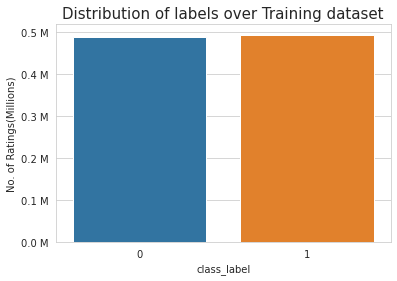

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
plt.title('Distribution of labels over Training dataset', fontsize=15)
sns.countplot(train_data.class_label)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

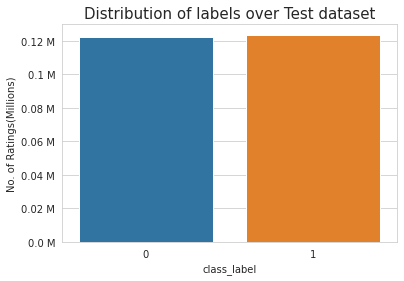

In [ ]:
fig, ax = plt.subplots()
plt.title('Distribution of labels over Test dataset', fontsize=15)
sns.countplot(test_data.class_label)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### 5.1.2 Analysis on the items purchased by a user

In [ ]:
no_of_items_purchased_per_user_train = train_data[train_data.class_label==1].groupby(by='user_id')['class_label'].count().sort_values(ascending=False)

no_of_items_purchased_per_user_train.head()

user_id
1111457    6225
1112690    5491
1112743    4638
1112192    4349
1111994    4239
Name: class_label, dtype: int64

In [ ]:
no_of_items_purchased_per_user_test = test_data[test_data.class_label==1].groupby(by='user_id')['class_label'].count().sort_values(ascending=False)

no_of_items_purchased_per_user_test.head()

user_id
1111457    1504
1112690    1401
1112743    1161
1112192    1089
1111994    1074
Name: class_label, dtype: int64

In [ ]:
no_of_items_purchased_per_user_train.describe()

count    1488.000000
mean      332.158602
std       581.509037
min         1.000000
25%        27.000000
50%       102.500000
75%       394.250000
max      6225.000000
Name: class_label, dtype: float64

> _There,  is something interesting going on with the quantiles.._

In [ ]:
quantiles = no_of_items_purchased_per_user_train.quantile(np.arange(0,1.01,0.01), interpolation='higher')

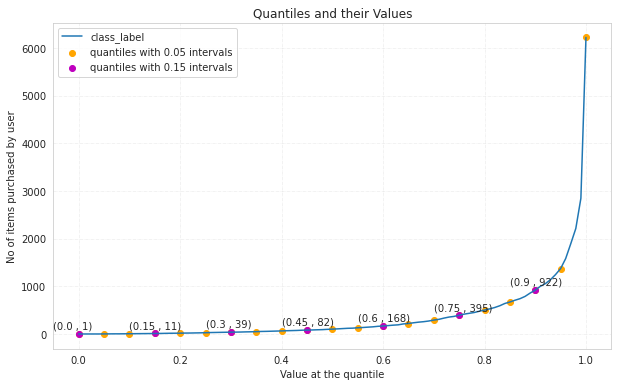

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize=(10,6))

plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
ax.scatter(x=quantiles.index[::5], y=quantiles.values[::5],
                   c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
ax.scatter(x=quantiles.index[::15], y=quantiles.values[::15],
                   c='m', label="quantiles with 0.15 intervals")
plt.ylabel('No of items purchased by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# Add x, y gridlines
ax.grid(b=True, color='grey',
                linestyle='-.', linewidth=0.5,
                alpha=0.2)

# annotate the 25th, 50th, 75th and 100th percentile values....
for x, y in zip(quantiles.index[::15], quantiles[::15]):
            ax.annotate(s="({} , {})".format(x, y), xy=(x, y),
                        xytext=(x-0.05, y+100))


plt.show()

In [ ]:
quantiles[::5]

0.00       1
0.05       2
0.10       6
0.15      11
0.20      18
0.25      27
0.30      39
0.35      50
0.40      65
0.45      82
0.50     103
0.55     131
0.60     168
0.65     220
0.70     293
0.75     395
0.80     503
0.85     672
0.90     922
0.95    1373
1.00    6225
Name: class_label, dtype: int64

__how many ratings at the last 5% of all ratings__??

In [ ]:
print('\n No of items purchased at last 5 percentile : {}\n'.format(sum(no_of_items_purchased_per_user_train>= 1373)) )


 No of items purchased at last 5 percentile : 75



In [ ]:
no_of_items_purchased_per_user_train.quantile(np.arange(.95, 1.0, 0.01), interpolation='higher')

0.95    1373
0.96    1584
0.97    1894
0.98    2216
0.99    2850
1.00    6225
Name: class_label, dtype: int64

In [ ]:
no_of_items_purchased_per_user_train.quantile(np.arange(.99, 1.0, 0.001), interpolation='higher')

0.990    2850
0.991    2853
0.992    3099
0.993    3227
0.994    3494
0.995    3689
0.996    3809
0.997    4239
0.998    4638
0.999    5491
1.000    6225
Name: class_label, dtype: int64

### 5.1.3 Analysis on number of items sold 

In [ ]:
no_of_items_sold_in_train = train_data[train_data.class_label==1].groupby(by='item_id')['class_label'].count().sort_values(ascending=False)

no_of_items_sold_in_train.head()

item_id
211659    174
211666    169
211687    166
211673    164
211694    163
Name: class_label, dtype: int64

In [ ]:
no_of_items_sold_in_test = test_data[test_data.class_label==1].groupby(by='item_id')['class_label'].count().sort_values(ascending=False)

no_of_items_sold_in_test.head()

item_id
211694    47
211673    47
276193    45
211687    44
211666    43
Name: class_label, dtype: int64

In [ ]:
quantiles_of_items_sold = no_of_items_sold_in_train.quantile(np.arange(0,1.01,0.01), interpolation='higher')

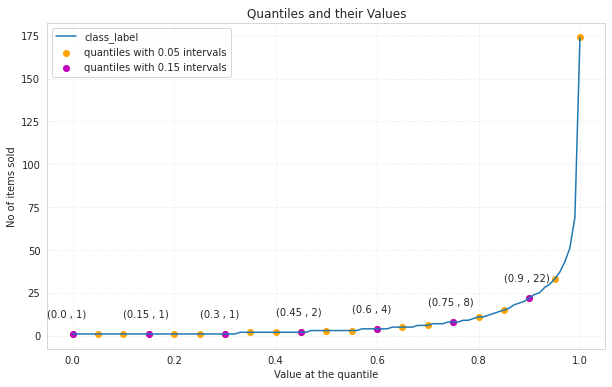

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize=(10,6))

plt.title("Quantiles and their Values")
quantiles_of_items_sold.plot()
# quantiles with 0.05 difference
ax.scatter(x=quantiles_of_items_sold.index[::5], y=quantiles_of_items_sold.values[::5],
                   c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
ax.scatter(x=quantiles_of_items_sold.index[::15], y=quantiles_of_items_sold.values[::15],
                   c='m', label="quantiles with 0.15 intervals")
plt.ylabel('No of items sold')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# Add x, y gridlines
ax.grid(b=True, color='grey',
                linestyle='-.', linewidth=0.5,
                alpha=0.2)

# annotate the 25th, 50th, 75th and 100th percentile values....
for x, y in zip(quantiles_of_items_sold.index[::15], quantiles_of_items_sold[::15]):
            ax.annotate(s="({} , {})".format(x, y), xy=(x, y),
                        xytext=(x-0.05, y+10))


plt.show()

In [ ]:
quantiles_of_items_sold[::5]

0.00      1
0.05      1
0.10      1
0.15      1
0.20      1
0.25      1
0.30      1
0.35      2
0.40      2
0.45      2
0.50      3
0.55      3
0.60      4
0.65      5
0.70      7
0.75      8
0.80     11
0.85     16
0.90     23
0.95     35
1.00    182
Name: class_label, dtype: int64

In [ ]:
no_of_items_sold_in_train.quantile(np.arange(.95, 1.0, 0.01), interpolation='higher')

0.95     35
0.96     39
0.97     45
0.98     53
0.99     72
1.00    182
Name: class_label, dtype: int64

In [ ]:
no_of_items_sold_in_train.quantile(np.arange(.99, 1.0, 0.001), interpolation='higher')

0.990     72
0.991     75
0.992     78
0.993     80
0.994     84
0.995     89
0.996     98
0.997    107
0.998    115
0.999    128
1.000    182
Name: class_label, dtype: int64

## 5.2 Cold Start problem

### 5.2.1 Cold Start problem with Users

In [ ]:
total_users = len(np.unique(all_deals_with_series_data.user_id))
users_train = len(train_data['user_id'].unique())
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 1681

Number of Users in Train data : 1681

No of Users that didn't appear in train data: 0(0.0 %) 
 


> We might have to handle __new users__ ( ___0___ ) who didn't appear in train data.

### 5.2.2 Cold Start problem with Items

In [ ]:
total_items = len(np.unique(all_deals_with_series_data.item_id))
items_train = len(train_data['item_id'].unique())
new_items = total_items - items_train

print('\nTotal number of Items  :', total_items)
print('\nNumber of Users in Train data :', items_train)
print("\nNo of Items that didn't appear in train data: {}({} %) \n ".format(new_items,
                                                                        np.round((new_items/total_items)*100, 2)))


Total number of Items  : 66745

Number of Users in Train data : 66739

No of Items that didn't appear in train data: 6(0.01 %) 
 


> We might have to handle __5 items__ (small comparatively) in test data

## 5.3 Plot with all features using Dimensionality Reduction techinque tSNE

In [ ]:
# source:https://www.askpython.com/python/examples/plot-k-means-clusters-python

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
 
#Load Data
data = train_data.drop(['user_id','item_id','class_label'], axis=1)
N = 50000
sample_index_numbers = np.random.choice(np.arange(data.shape[0]), N, replace=False)
sampled_processed_deals_data = data.iloc[sample_index_numbers]
sampled_processed_deals_labels = train_data['class_label'].iloc[sample_index_numbers]

# t-SNE
tsne = TSNE(n_components=2, n_jobs=-1)
df = tsne.fit_transform(sampled_processed_deals_data)

#Initialize the class object
#kmeans = KMeans(n_clusters= 8, n_jobs=-1)

#predict the labels of clusters.
#label = kmeans.fit_predict(df)

#Getting the Centroids
#centroids = kmeans.cluster_centers_

#Getting unique labels
#u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize=(15,10))
sns.scatterplot(
    df[:,0], df[:,1],
    hue=sampled_processed_deals_labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.show()


KeyboardInterrupt: ignored

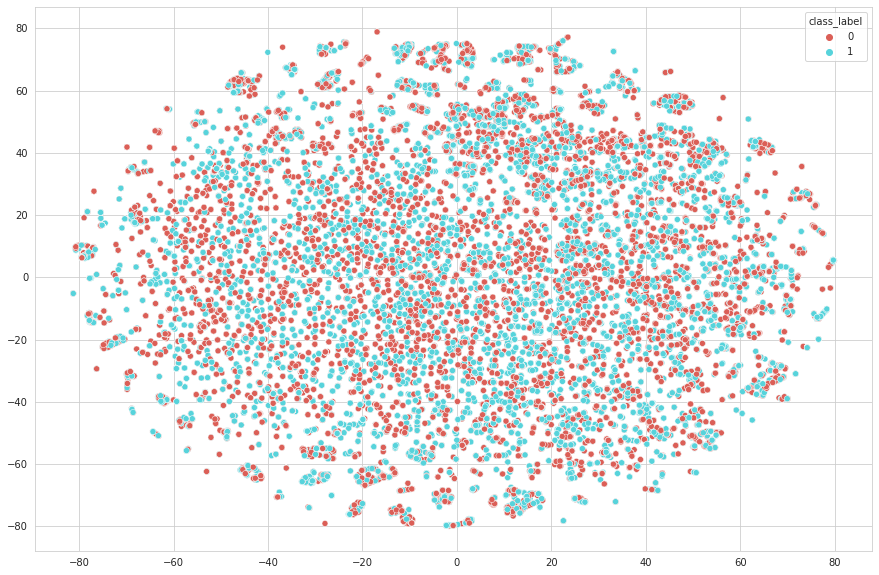

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    df[:,0], df[:,1],
    data=df,
    hue=sampled_processed_deals_labels,
    palette=sns.color_palette("hls", 2),
)
plt.show()


#6 Modeling

prepare Train data & prepare CV data
Prepare Test data
Model training......
Done
save the model
save y_train, y_test, y_train_pred, y_test_pred
Train f1 score 0.9921919414350006
Test f1 score 0.9925683998962654


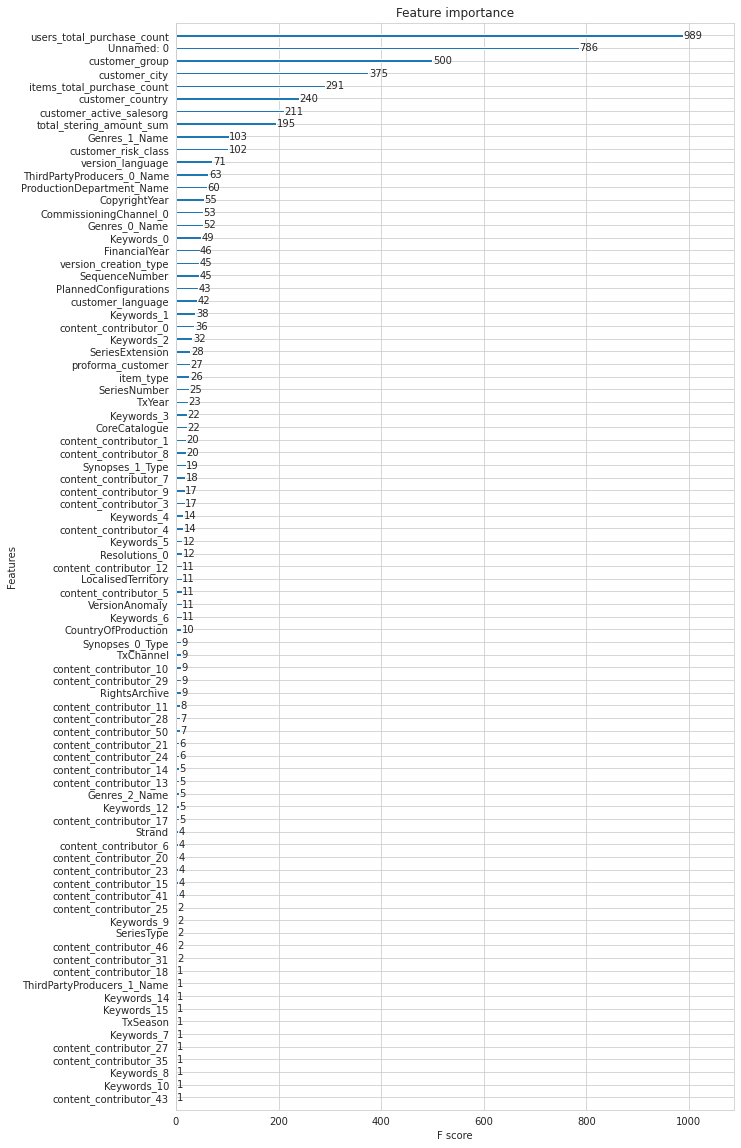

Train confusion_matrix


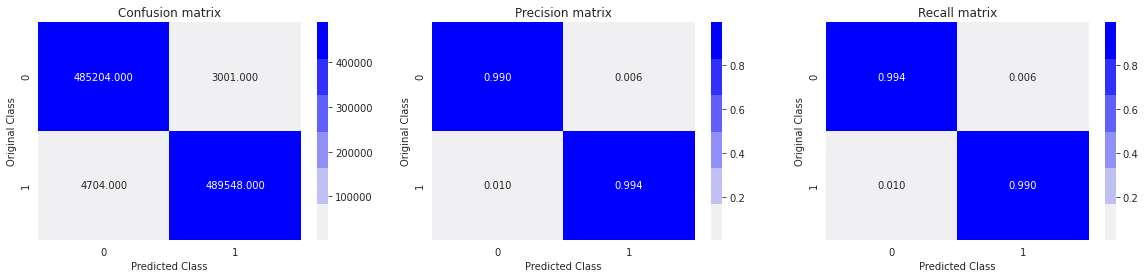

Test confusion_matrix


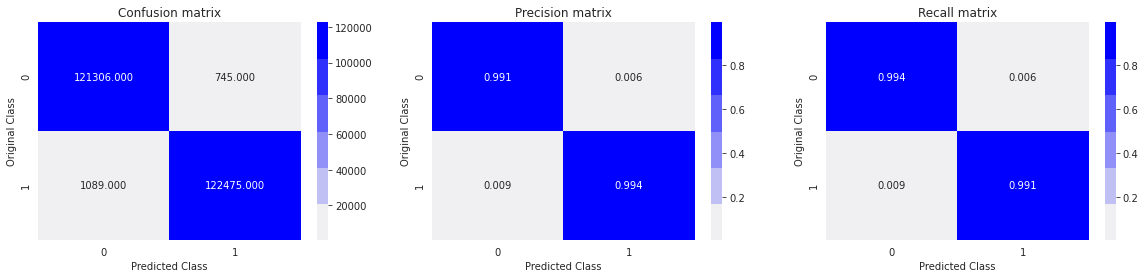

In [ ]:
def model_training_pipeline(version_number):
  train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

  train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
  test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)


  print('prepare Train data & prepare CV data')
  x_train = train_data.drop(['user_id','item_id','class_label'], axis=1)
  y_train = train_data['class_label']

  print('Prepare Test data')
  x_test = test_data.drop(['user_id','item_id', 'class_label'], axis=1)
  y_test = test_data['class_label']

  x_train.shape, x_test.shape

  print('Model training......')
  xgb_clf = XGBClassifier(n_estimators=800)
  xgb_clf.fit(x_train, y_train)
  print('Done')

  filename = '/production_data/xgb_clf_{0}.model'.format(version_number)

  print('save the model')
  xgb_clf.save_model(drive_path+filename)

  y_train_pred = xgb_clf.predict(x_train)
  y_test_pred = xgb_clf.predict(x_test)

  print('save y_train, y_test, y_train_pred, y_test_pred') 
  pd.to_pickle(y_train, drive_path+'/production_data/y_train.pkl')
  pd.to_pickle(y_test, drive_path+'/production_data/y_test.pkl')

  pd.to_pickle(y_train_pred, drive_path+'/production_data/y_train_pred.pkl')
  pd.to_pickle(y_test_pred, drive_path+'/production_data/y_test_pred.pkl')

  print('Train f1 score',f1_score(y_train,y_train_pred))
  print('Test f1 score',f1_score(y_test,y_test_pred))

  %matplotlib inline
  fig, ax = plt.subplots(figsize=(10, 20))
  xgb.plot_importance(xgb_clf, ax=ax)
  plt.show()

  def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
  
  print('Train confusion_matrix')
  plot_confusion_matrix(y_train,y_train_pred)
  print('Test confusion_matrix')
  plot_confusion_matrix(y_test,y_test_pred)

model_training_pipeline(1.4)

In [ ]:
# load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
def load_sps_data(sps_file_path):
  sps_data = pd.read_csv(sps_file_path, names = ['orderNumber', 'SPMASALE_TOTAL_STER'],
                            sep=',', encoding='ISO-8859-1')
  sps_data.orderNumber = sps_data.orderNumber.apply(lambda s: s.replace('ï»¿',''))

  print(sps_data.shape)
  return sps_data


# load the legacy deals data of rightsline 
def load_legacy_deals_data(legacy_deals_file_path):

  legacy_deals = pd.read_csv(legacy_deals_file_path,
                            names = ['deal_id', 'sps_id', 'user_id', 'country', 'item_id', 'item_type'],
                            sep=',', encoding='ISO-8859-1')

  legacy_deals.deal_id = legacy_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))
  legacy_deals.drop('country', axis=1, inplace=True)
  legacy_deals.drop_duplicates(inplace=True)

  legacy_deals.sps_id.fillna('NaN', inplace=True)

  print(legacy_deals.shape)
  return legacy_deals


# map the total_ster_amount_dict to legacy_deals data

def map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data):

  count_of_sps_ids = Counter(legacy_deals.sps_id.values)
  total_ster_amount_dict = {i[0]:i[1] for i in sps_data[['orderNumber', 'SPMASALE_TOTAL_STER']].values}

  total_ster_amount = {}
  sps_orderNumbers = sps_data.orderNumber.unique()

  for sps_id in tqdm(legacy_deals.sps_id.unique()):
      sps_ids = sps_id.split('|')
      amounts = []
      for id in sps_ids:
          if id in sps_orderNumbers:
              amounts.append(total_ster_amount_dict[id])
          else:
              amounts.append(np.NAN)
      total_ster_amount[sps_id]=np.sum(amounts)

  legacy_deals['total_ster_amount'] = legacy_deals.sps_id.apply(lambda id: total_ster_amount[id]/count_of_sps_ids[id])
      
  legacy_deals.drop(['sps_id'],axis=1,inplace=True)

  legacy_deals = legacy_deals[['deal_id', 'user_id', 'item_id', 'total_ster_amount', 'item_type']]
  legacy_deals.columns = ['deal_id', 'user_id', 'item_id', 'total_stering_amount', 'item_type']

  print(legacy_deals.shape)
  return legacy_deals

# load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
def load_new_deals_data(new_deals_file_path):

  new_deals = pd.read_csv(new_deals_file_path, 
                          names = ['deal_id', 'user_id', 'item_id', 'country', 'total_stering_amount', 'item_type'],
                          
                          sep=',', encoding='ISO-8859-1')

  new_deals.deal_id = new_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))

  new_deals.drop('country',axis=1,inplace=True)

  print(new_deals.shape)
  return new_deals

def create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data):

  all_deals_data = all_deals_data.groupby(['user_id','item_id', 'item_type']).agg({'total_stering_amount': 'sum'}).rename(columns={'total_stering_amount': 'total_stering_amount_sum'}).reset_index()

  users_total_purchase_count = Counter(all_deals_data.user_id)
  items_total_purchase_count = Counter(all_deals_data.item_id)

  all_deals_data['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count)
  all_deals_data['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count)
  all_deals_data['class_label'] = 1

  print(all_deals_data.shape)
  return all_deals_data

#Create Dummy Data with Label 0

def create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path):
  
  # load the saved "dummy_data" file for further processing 
  dummy_data = pd.read_pickle(dummy_data_file_path)

  real_data = list(zip(all_deals_data.user_id.values, all_deals_data.item_id.values))+list(dummy_data)

  uids = all_deals_data.user_id.unique()
  iids = all_deals_data.item_id.unique()

  while (len(dummy_data)<all_deals_data.shape[0]):
      uid = uids[random.randint(0, len(uids)-1)]
      iid = iids[random.randint(0, len(iids)-1)]
      if not (uid, iid) in real_data:
          dummy_data.add((uid,iid))
      else:
          continue
  
  return dummy_data

def create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data):

  item_type_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.item_type.values)))}
  users_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.user_id.values, all_deals_data.users_total_purchase_count.values)))}
  items_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.items_total_purchase_count.values)))}

  dummy_data_with_0_label = pd.DataFrame(data=dummy_data, columns=['user_id','item_id'])
  dummy_data_with_0_label['item_type'] = all_deals_data.item_id.map(item_type_mapping)
  dummy_data_with_0_label['total_stering_amount_sum'] = 0.0
  dummy_data_with_0_label['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count_mapping)
  dummy_data_with_0_label['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count_mapping)
  dummy_data_with_0_label['class_label'] = 0

  print(dummy_data_with_0_label.shape)
  return dummy_data_with_0_label

# Content Mappings
def load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path):
  
  all_catalog = pd.read_csv(all_catalog_file_path, encoding='ISO-8859-1', names=['series_id','series_temp','child_1','child_1_temp', 'child_2','child_2_temp', 'child_3','child_3_temp'])
  all_catalog.series_id = all_catalog.series_id.apply(lambda s: str(s).replace('ï»¿',''))
  print(all_catalog.shape)

  s1 = set(zip(all_catalog['child_1_temp'], all_catalog['child_1'], all_catalog['series_id']))
  s2 = set(zip(all_catalog['child_2_temp'], all_catalog['child_2'], all_catalog['series_id']))
  s3 = set(zip(all_catalog['child_3_temp'], all_catalog['child_3'], all_catalog['series_id']))

  s_all = set.union(s1,s2,s3)
  all_contents_mapped_to_series_data = pd.DataFrame(s_all,columns=['content_type', 'content_id', 'series_id'])
  all_contents_mapped_to_series_data = all_contents_mapped_to_series_data[~all_contents_mapped_to_series_data.content_type.isna()]
  all_contents_mapped_to_series_data[['content_id', 'series_id']]=all_contents_mapped_to_series_data[['content_id', 'series_id']].astype(int)
  print(all_contents_mapped_to_series_data.shape)
  
  all_contents_mapped_to_series_data.drop_duplicates(inplace=True)

  return all_contents_mapped_to_series_data

# Map the "concatenated_data" data with "version_creation_type_language"

def map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id):
  
  version_creation_type_language = pd.read_csv(version_creation_type_language_file_path)

  all_deals_with_series_id = all_deals_with_series_id.merge(version_creation_type_language, left_on='item_id', right_on='_id')
  all_deals_with_series_id.drop('_id',axis=1,inplace=True)

  print(all_deals_with_series_id.shape)
  return all_deals_with_series_id, version_creation_type_language

# High level data of Series
# To create New/Update Series data using Collection
#https://stackoverflow.com/questions/51359783/python-flatten-multilevel-nested-json

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def create_series_df(series_file_path):

  import json

  # Opening JSON file
  f = open(series_file_path)
    
  # returns JSON object as 
  # a dictionary
  data = json.load(f)

  out_data = []  
  # Iterating through the json
  # list
  for i in tqdm(data):
    out_data.append(flatten_json(i))
    
  # Closing file
  f.close()

  #create dataframe
  series_df = pd.DataFrame.from_dict(out_data)

  # create the formatted data
  print('Orginal shape')
  print(series_df.shape)
  print(' ')

  for i in range(223):
      firstName = series_df['ContentContributions_Data_{0}_Contributor_Data_FirstName'.format(i)]
      lastName = series_df['ContentContributions_Data_{0}_Contributor_Data_LastName'.format(i)]
      series_df['content_contributor_{0}'.format(i)]=firstName+' '+lastName
              
  print('After combining First & Last Names shape')
  print(series_df.shape)
  print(' ')

  ContentContributions_cols = [col for col in series_df.columns if 'ContentContributions' in col]
  series_df.drop(ContentContributions_cols,axis=1,inplace=True)

  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50', 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data = series_df[series_df.Status=='Approved'][use_columns]
  
  print('After dropping Non-Approved rows & ContentContributions columns')
  print(rl_series_data.shape)

  bool_feat = ['RightsArchive', 'CoreCatalogue', 'PremiumContent', 'VersionAnomaly']
  int_feat = ['_id', 'SequenceNumber', 'CopyrightYear', 'TxYear']
  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']
  drop_features = ['content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data.drop(drop_features,axis=1,inplace=True)

  cat_feat = list(set(use_columns)-set(bool_feat)-set(int_feat))

  rl_series_data[cat_feat] = rl_series_data[cat_feat].astype(str)
  rl_series_data[int_feat] = rl_series_data[int_feat].astype(float)
  rl_series_data[bool_feat] = rl_series_data[bool_feat].astype(bool)
  rl_series_data._id = rl_series_data._id.astype(int)

  return rl_series_data

# Map content_contributors series data to "all_deals_with_series_id"

def map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id):

  content_contributor_features = ['content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']#, 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']
  rl_content_contributors_data = pd.read_csv(rl_series_data_file_path, usecols=['_id', 'Genres_0_Name']+content_contributor_features) 
  print(rl_content_contributors_data.shape)

  for c in tqdm(content_contributor_features):
    rl_content_contributors_data[c] = rl_content_contributors_data['Genres_0_Name']+" :: "+rl_content_contributors_data[c]
  
  all_deals_with_content_contributors_data = all_deals_with_series_id[all_deals_with_series_id.class_label==1].merge(rl_content_contributors_data, left_on='series_id', right_on='_id')

  all_deals_with_content_contributors_data.drop(['Genres_0_Name', 'series_id', '_id', 'item_id', 'version_language', 'item_type', 'total_stering_amount_sum', 'users_total_purchase_count', 'items_total_purchase_count', 'class_label', 'version_creation_type'], axis=1, inplace=True)

  print(all_deals_with_content_contributors_data.shape)
  
  return all_deals_with_content_contributors_data, content_contributor_features

def create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features):

  all_unique_contrib = all_deals_with_content_contributors_data[content_contributor_features].values.flatten()
  all_unique_contrib_dict = dict(pd.Series(all_unique_contrib).value_counts())

  all_users_contrib_data = {}

  for uid in tqdm(all_deals_with_content_contributors_data['user_id'].unique()):
    all_contrib = all_deals_with_content_contributors_data[all_deals_with_content_contributors_data.user_id==uid][content_contributor_features].values.flatten()
    all_users_contrib_data[uid] = dict(pd.Series(all_contrib).value_counts())

  user_contributor_interaction_sparse_matrix = {}

  user_contributor_interaction_sparse_matrix = csr_matrix((len(all_unique_contrib_dict), all_deals_with_content_contributors_data.user_id.nunique()), dtype=np.uint8)

  user_index_map = {user: idx for idx, user in enumerate(all_deals_with_content_contributors_data.user_id.unique())}
  contrib_index_map = {contrib: idx for idx, contrib in enumerate(all_unique_contrib_dict.keys())}

  for user, contrib_data in tqdm(all_users_contrib_data.items()):
    for contrib, count in contrib_data.items():
      row = contrib_index_map[contrib]
      col = user_index_map[user]
      user_contributor_interaction_sparse_matrix[row, col]=count
  
  return user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix

# High level Customer Data
def load_customer_data(cusotmer_data_path):

  customer_df = pd.read_csv(cusotmer_data_path, sep=',', encoding='ISO-8859-1')

  customer_df.proforma_customer.fillna(False, inplace=True)
  customer_df.fillna('NaN', inplace=True)

  customer_df.drop(['sap_cstomer_number','contact_name'],axis=1,inplace=True)

  print(customer_df.shape)
  return customer_df

# Map series data to SeriesCollections

def create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data):

  all_seriesCollections_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Series Collection'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_seriesCollections_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  seriesCollection_title = pd.read_csv(seriesCollection_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  seriesCollection_title.dropna(inplace=True)
  seriesCollection_title.RecordID = seriesCollection_title.RecordID.astype(int)

  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_seriesCollections_with_series_data.drop('_id',axis=1,inplace=True)
  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(seriesCollection_title, left_on='content_id', right_on='RecordID')
  #all_seriesCollections_with_series_data.drop_duplicates(inplace=True)
  all_seriesCollections_with_series_data['title_without_version_creation_type'] = all_seriesCollections_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  #all_seriesCollections_with_series_data['duplicate_count'] = all_seriesCollections_with_series_data['title_without_version_creation_type'].map(Counter(all_seriesCollections_with_series_data['title_without_version_creation_type']))
  all_seriesCollections_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_seriesCollections_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'] ,axis=1,inplace=True)

  print(all_seriesCollections_with_series_data.shape)
  return all_seriesCollections_with_series_data

# Map series data to EpisodeVersions

def create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data):

  all_episodeVersions_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Episode Version'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_episodeVersions_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  all_episodeVersions_with_series_data.drop_duplicates(inplace=True)

  episodeVersion_title = pd.read_csv(episodeVersion_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  episodeVersion_title.dropna(inplace=True)
  episodeVersion_title.RecordID = episodeVersion_title.RecordID.astype(int)

  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_episodeVersions_with_series_data.drop('_id',axis=1,inplace=True)
  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(episodeVersion_title, left_on='content_id', right_on='RecordID')
  all_episodeVersions_with_series_data['title_without_version_creation_type'] = all_episodeVersions_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  all_episodeVersions_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_episodeVersions_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'],axis=1,inplace=True)

  print(all_episodeVersions_with_series_data.shape)
  return all_episodeVersions_with_series_data

# Handling Categorical Features

def vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data):

  categoical_fetaures = [feat for feat in  train_data.columns if type(train_data[feat].iloc[0])==str]
  encode_objects_name = ["{0}_encode".format(col) for col in categoical_fetaures]

  for idx, feat in tqdm(enumerate(categoical_fetaures)):
      encode_objects_name[idx] = LabelEncoder()
      encode_objects_name[idx].fit(train_data[feat])

      #https://stackoverflow.com/questions/40321232/handling-unknown-values-for-label-encoding
      diff = [i for i in test_data[feat].unique() if i not in encode_objects_name[idx].classes_]
      if len(diff)>0:
          test_data[feat] = test_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
          encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
      train_data[feat]=encode_objects_name[idx].transform(train_data[feat])
      test_data[feat]=encode_objects_name[idx].transform(test_data[feat])

      if feat not in ['item_type', 'customer_group',
        'customer_city', 'customer_country', 'customer_active_salesorg',
        'customer_language', 'customer_risk_class']:
        sc_diff = [i for i in all_seriesCollections_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(sc_diff)>0:
            all_seriesCollections_with_series_data[feat] = all_seriesCollections_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_seriesCollections_with_series_data[feat]=encode_objects_name[idx].transform(all_seriesCollections_with_series_data[feat])

        epv_diff = [i for i in all_episodeVersions_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(epv_diff)>0:
            all_episodeVersions_with_series_data[feat] = all_episodeVersions_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_episodeVersions_with_series_data[feat]=encode_objects_name[idx].transform(all_episodeVersions_with_series_data[feat])
    
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

# Handling Numerical Features
def impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data):

  numerical_fetaures = [feat for feat in  all_deals_with_series_data.columns 
                        if (type(all_deals_with_series_data[feat].iloc[0])!=str) & (feat not in ['user_id','item_id','class_label'])]
  scaler_objects_name = ["{0}_scaler".format(col) for col in numerical_fetaures]

  mean_imp_objects_name = ["{0}_mean_imp".format(col) for col in numerical_fetaures]

  for idx, feat in enumerate(numerical_fetaures):

      #Imputation of missing values
      mean_imp_objects_name[idx] = SimpleImputer(missing_values=np.nan, strategy='mean')
      mean_imp_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat] = mean_imp_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1))
      test_data[feat] = mean_imp_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1))

      # Standardization of numerical values
      scaler_objects_name[idx] = StandardScaler()
      scaler_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat]=scaler_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1) )
      test_data[feat]=scaler_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1) )

      if feat not in ['items_total_purchase_count', 'total_stering_amount_sum', 'users_total_purchase_count']:
        all_episodeVersions_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1))
        all_episodeVersions_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1) )

        all_seriesCollections_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1))
        all_seriesCollections_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1) )
  
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data
  
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

def get_dtypes(df):
  cols = df.dtypes.index
  col_dtypes = df.dtypes.values

  return {cols[idx]:str(col_dtypes[idx]) for idx in range(len(cols))}


#########################################################################
#########################################################################
#	Collaborative Filtering ##

# creating sparse matrix for seriesCollection & episodeVersion

def create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map, user_item_class_label_data):

  user_item_interaction_sparse_matrix = {}

  for content, data in {'Series Collection': seriesCollection_to_title_map, 'Episode Version': episodeVersion_to_title_map}.items():
    user_index_map = {user: idx for idx, user in enumerate(user_item_class_label_data.user_id.unique())}
    item_index_map = {item: idx for idx, item in enumerate(data.keys())}

    user_item_interaction_sparse_matrix[content] = csr_matrix((len(user_index_map), len(item_index_map)), dtype=np.uint8)

    content_ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]

    content_data = user_item_class_label_data[user_item_class_label_data.item_id.isin(content_ids)]

    user_item_interacted_data = list(zip(content_data.user_id.values, content_data.item_id.values))

    for (user, item) in tqdm(user_item_interacted_data):
      row = user_index_map[user]
      col = item_index_map[item]
      user_item_interaction_sparse_matrix[content][row, col]=1

  return user_item_interaction_sparse_matrix

# Compute User-User Similarity matrix
# save user_contributor_interaction_sparse_matrix

def create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix):
  start = datetime.now()
  c_c_sim_sparse = cosine_similarity(X=user_genre_contributor_interaction_sparse_matrix, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/production_data/c_c_sim_sparse.npz", c_c_sim_sparse)

  print("It's a ",c_c_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return c_c_sim_sparse
  
# Create recommendation function for new Item
def recommend_new_item_to_users(index_user_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data, c_c_sim_sparse, contrib_index_map, top_users = 10):

  contrib_wise_user = {}

  for contrib, idx in contrib_index_map.items():
      contrib_wise_user[contrib] = [index_user_map[i] for i in (~user_contributor_interaction_sparse_matrix[idx,:].toarray()).argsort().flatten()]

  
  top_users_per_genre_and_contrib = {}
  top_simillar_users_per_genre_and_contrib = {}

  for key, val in tqdm(contrib_wise_user.items()):
      all_items = []
      similarities = c_c_sim_sparse[contrib_index_map[key]].toarray().ravel()
      top_10_contribs = [index_contrib_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
      for contrib in top_10_contribs:
        top_10_indices = contrib_wise_user[contrib][:top_users]
        all_items.extend(top_10_indices)

      d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
      top_simillar_users_per_genre_and_contrib[key]=np.unique([i for i in production_data[production_data.user_id.isin(list(d_sorted_by_value.keys()))]['user_id'].values])[:top_users]
          
      top_users_per_genre_and_contrib[key]=contrib_wise_user[key][:top_users]
  
  return top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib

# SeriesCollection-SeriesCollection Similarity matrix

def create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix):
  start = datetime.now()
  sc_sc_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Series Collection'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/intermittent_saved_files/sc_sc_sim_sparse.npz", sc_sc_sim_sparse)
  print("Done..")

  print("It's a ",sc_sc_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return sc_sc_sim_sparse

# EpisodeVersion-EpisodeVersion Similarity matrix
def create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix):

  start = datetime.now()
  epv_epv_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Episode Version'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/intermittent_saved_files/epv_epv_sim_sparse.npz", epv_epv_sim_sparse)
  print("Done..")
  print("It's a ",epv_epv_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return epv_epv_sim_sparse

# Create recommendation function for new User
def recommendatation_for_new_user(user_country_genre_category_wise_items, sc_sc_sim_sparse, sc_to_index_map, index_to_sc_map, epv_epv_sim_sparse, epv_to_index_map, index_to_epv_map, top_users=10):
  
  top_items_per_user_country_genre_category = {}
  top_simillar_items_per_user_country_genre_category = {}

  for country, content_data in tqdm(user_country_genre_category_wise_items.items()):
    top_items_per_user_country_genre_category[country] = {}
    top_simillar_items_per_user_country_genre_category[country] = {}
    for content, genre_data in content_data.items():
      top_items_per_user_country_genre_category[country][content] = {}
      top_simillar_items_per_user_country_genre_category[country][content] = {}
      for genre, item_data in genre_data.items():
        all_items = []
        for it_id in item_data[:top_users]:
            if content=='seriesCollection':
              similarities = sc_sc_sim_sparse[sc_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_sc_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
            elif content=='episodeVersion':
              similarities = epv_epv_sim_sparse[epv_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_epv_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
        d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
        if content=='seriesCollection':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
        elif content=='episodeVersion':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
    
  return top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category


In [ ]:
#global train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, production_data, user_item_class_label_data, seriesCollection_to_title_map, episodeVersion_to_title_map, encode_value_to_ver_lang_map, customer_to_name_map, encode_value_to_customer_language_map, country_to_encoded_value_map, encode_value_to_country_map, genre_to_encoded_value_map, item_type_to_encoded_value_map, user_lookup_data, item_lookup_data, user_item_class_label_data, user_item_interaction_sparse_matrix, c_c_sim_sparse, user_index_map, index_user_map, contrib_index_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data, sc_sc_sim_sparse, epv_epv_sim_sparse, user_country_genre_category_wise_items

def collabrative_filtering_data_and_training_pipeline():
    train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

    train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
    test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)
    all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)
    all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)


    print('Concetenate two dataframes train and test')
    production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
    print(production_data.shape)
    production_data.head()

    print('save "user_item_class_label_data" to csv file')
    production_data[['user_id', 'item_id', 'items_total_purchase_count', 'version_language', 'OriginalLanguage', 'Genres_0_Name',	'Genres_1_Name', 'customer_country', 'customer_group', 'customer_language', 'class_label']].to_csv(drive_path+'/production_data/user_item_class_label_data.csv',index=False)

    print('load the saved "user_item_class_label_data" file for further processing')
    user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')
    print(user_item_class_label_data.shape)

    print('SeriesCollection to Title Mapping')
    seriesCollection = pd.read_csv(drive_path+'/raw_data/seriesCollection.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    seriesCollection.dropna(inplace=True)
    seriesCollection.RecordID = seriesCollection.RecordID.astype(int)
    seriesCollection_to_title_map = {i[0]:i[1] for i in seriesCollection.values}

    print('save seriesCollection_to_title_map')
    pd.to_pickle(seriesCollection_to_title_map, drive_path+'/production_data/seriesCollection_to_title_map.pkl')

    print('EpisodeVersion to Title Mapping')
    episodeVersion = pd.read_csv(drive_path+'/raw_data/episodeVersion.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    episodeVersion.dropna(inplace=True)
    episodeVersion.RecordID = episodeVersion.RecordID.astype(int)
    episodeVersion_to_title_map = {i[0]:i[1] for i in episodeVersion.values}
    
    print('save episodeVersion_to_title_map')
    pd.to_pickle(episodeVersion_to_title_map, drive_path+'/production_data/episodeVersion_to_title_map.pkl')

    print('Version_Language to Encode Value Mapping')
    version_creation_type_language = pd.read_csv(drive_path+'/raw_data/version_creation_type_language.csv')
    ver_df = version_creation_type_language[['_id', 'version_language']].merge(user_item_class_label_data[['item_id', 'version_language']], left_on='_id', right_on='item_id')
    ver_lang_to_encode_map = {ver_lang:encode_value for (ver_lang, encode_value) in set(zip(ver_df.version_language_x.values, ver_df.version_language_y.values))}
    ver_lang_to_encode_map['<unknown>'] = len(ver_lang_to_encode_map)+1
    pd.to_pickle(ver_lang_to_encode_map, drive_path+'/production_data/ver_lang_to_encode_map.pkl')
    encode_value_to_ver_lang_map = {encode: ver_lang for ver_lang, encode in ver_lang_to_encode_map.items()} 


    print('User to Name Mapping')
    customer_df = pd.read_csv(drive_path+'/raw_data/customer_data.csv', sep=',', encoding='ISO-8859-1')
    cust_df = customer_df.merge(user_item_class_label_data, on='user_id')
    customer_to_name_map = {user_id:user_name for (user_id, user_name) in set(zip(cust_df.user_id, cust_df.contact_name))}
    pd.to_pickle(customer_to_name_map, drive_path+'/production_data/customer_to_name_map.pkl')

    print('Customer Language to Encoded Value Mapping')
    customer_language_to_encode_value_map = {customer_language:encode_value for (customer_language, encode_value) in set(zip(cust_df.customer_language_x.values, cust_df.customer_language_y.values))}
    pd.to_pickle(customer_language_to_encode_value_map, drive_path+'/production_data/customer_language_to_encode_value_map.pkl')
    encode_value_to_customer_language_map = {encode:lang for lang, encode in customer_language_to_encode_value_map.items()}


    print('Country to Encoded Value Mapping')
    country_to_encoded_value_map = {country: encoded_value for (country, encoded_value) in set(zip(cust_df.customer_country_x.values, cust_df.customer_country_y.values))}
    
    print('save country_to_encoded_value_map')
    pd.to_pickle(country_to_encoded_value_map, drive_path+'/production_data/country_to_encoded_value_map.pkl')
    encode_value_to_country_map = {encode:country for country, encode in country_to_encoded_value_map.items()}

    print('Genre to Encoded Value Mapping')
    all_deals_with_series_id = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv', usecols=['item_id','series_id'])
    rl_series_data = pd.read_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', usecols=['_id', 'Genres_0_Name','Genres_1_Name']) 
    gc = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id').merge(user_item_class_label_data[['item_id','Genres_0_Name','Genres_1_Name']], on='item_id')
    genre_to_encoded_value_map = {genre:encoded_value for (genre, encoded_value) in set(zip(gc['Genres_0_Name_x'].values, gc['Genres_0_Name_y'].values))}
    
    print('save genre_to_encoded_value_map')
    pd.to_pickle(genre_to_encoded_value_map, drive_path+'/production_data/genre_to_encoded_value_map.pkl')
    sub_genre_to_encoded_value_map = {sub_genre:encoded_value for (sub_genre, encoded_value) in set(zip(gc['Genres_1_Name_x'].values, gc['Genres_1_Name_y'].values))}
    
    print('save sub_genre_to_encoded_value_map')
    pd.to_pickle(sub_genre_to_encoded_value_map, drive_path+'/production_data/sub_genre_to_encoded_value_map.pkl')

    print('Content Type to Encoded Value Mapping')
    item_type_to_encoded_value_map = {'Episode Version': 0, 'Format': 1, 'Series Collection': 2}
    
    print('save item_type_to_encoded_value_map')
    pd.to_pickle(item_type_to_encoded_value_map, drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

    print('User Lookup Data')
    user_features = ['user_id', 'users_total_purchase_count', 'customer_group', 'customer_city', 'customer_country', 'customer_active_salesorg', 'proforma_customer', 'customer_language', 'customer_risk_class']
    user_lookup_data = production_data.copy()[user_features]
    print('Before dropping duplicates: ', user_lookup_data.shape)
    user_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', user_lookup_data.shape)
    
    print('save "user_lookup_data" to csv file')
    user_lookup_data.to_csv(drive_path+'/production_data/user_lookup_data.csv',index=False)
    print('reduce the memory size of user_lookup_data')
    user_lookup_data, _ = reduce_mem_usage(user_lookup_data)
    print('save "user_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(user_lookup_data),drive_path+'/production_data/user_lookup_data_dtypes.pkl')

    print('Item Lookup Data')
    item_lookup_data = production_data.copy().drop(user_features+['total_stering_amount_sum', 'class_label'],axis=1)
    print('Before dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.head()
    print('save "item_lookup_data" to csv file')
    item_lookup_data.to_csv(drive_path+'/production_data/item_lookup_data.csv',index=False)
    print('reduce the memory size of item_lookup_data')
    item_lookup_data, _ = reduce_mem_usage(item_lookup_data)
    print('save "item_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(item_lookup_data),drive_path+'/production_data/item_lookup_data_dtypes.pkl')

    print("SeriesCollection Lookup Data")
    all_seriesCollections_with_series_data = all_seriesCollections_with_series_data[all_seriesCollections_with_series_data.item_id.isin(seriesCollection_to_title_map.keys())]
    print(all_seriesCollections_with_series_data.shape)
    print('save "all_seriesCollections_with_series_data" to csv file')
    all_seriesCollections_with_series_data.to_csv(drive_path+'/production_data/all_seriesCollections_with_series_data.csv',index=False)

    print("EpisodeVersion Lookup Data")
    all_episodeVersions_with_series_data = all_episodeVersions_with_series_data[all_episodeVersions_with_series_data.item_id.isin(episodeVersion_to_title_map.keys())]
    print(all_episodeVersions_with_series_data.shape)
    print('save "all_episodeVersions_with_series_data" to csv file')
    all_episodeVersions_with_series_data.to_csv(drive_path+'/production_data/all_episodeVersions_with_series_data.csv',index=False)

    print('load the saved "user_item_class_label_data" file for further processing')
    user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')

    print('Creating sparse matrix for seriesCollection & episodeVersion')
    user_item_interaction_sparse_matrix = create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map, user_item_class_label_data)
    print('save "user_item_interaction_sparse_matrix" to pkl file')
    pd.to_pickle(user_item_interaction_sparse_matrix, drive_path+"/production_data/user_item_interaction_sparse_matrix.pkl")

    print('Compute User-User Similarity matrix')
    user_genre_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')
    c_c_sim_sparse = create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix)

    print('load user_index_map')
    user_index_map = pd.read_pickle(drive_path+'/production_data/user_index_map.pkl')
    index_user_map = {idx: user for user, idx in user_index_map.items()}

    print('load contrib_index_map')
    contrib_index_map = pd.read_pickle(drive_path+'/production_data/contrib_index_map.pkl')
    index_contrib_map = {idx: contrib for contrib, idx in contrib_index_map.items()}

    print('load user_contributor_interaction_sparse_matrix')
    user_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

    print('Concetenate two dataframes train and test')
    production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
    print(production_data.shape)

    top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib = recommend_new_item_to_users(index_user_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data, c_c_sim_sparse, contrib_index_map, top_users = 10)

    print('save top_users_per_genre & top_simillar_users_per_genre files')
    pd.to_pickle(top_users_per_genre_and_contrib, drive_path+'/production_data/top_users_per_genre_and_contrib.pkl')
    pd.to_pickle(top_simillar_users_per_genre_and_contrib, drive_path+'/production_data/top_simillar_users_per_genre_and_contrib.pkl')

    print('SeriesCollection-SeriesCollection Similarity matrix')
    sc_sc_sim_sparse = create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix)

    print('EpisodeVersion-EpisodeVersion Similarity matrix')
    epv_epv_sim_sparse = create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix)

    print('Create recommendation function for new User')
    #user_country_genre_category_wise_items = { i: production_data[production_data.customer_country==i]['item_id'].value_counts().index for i in production_data['customer_country'].unique()}

    user_country_genre_category_wise_items = {}

    for country in country_to_encoded_value_map.keys():
      user_country_genre_category_wise_items[country] = {}
      for content, data in {'seriesCollection': seriesCollection_to_title_map, 'episodeVersion': episodeVersion_to_title_map}.items():
        ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]
        data0 = user_item_class_label_data[user_item_class_label_data.item_id.isin(ids)]
        user_country_genre_category_wise_items[country][content] = {}
        for genre in genre_to_encoded_value_map.keys():
          cond1 = data0.customer_country==country_to_encoded_value_map[country]
          cond2 = data0['Genres_0_Name']==genre_to_encoded_value_map[genre]
          user_country_genre_category_wise_items[country][content][genre]=data0[cond1 & cond2]['item_id'].value_counts().index

      sc_to_index_map = {sc: idx for idx, sc in enumerate(seriesCollection_to_title_map.keys())}
      index_to_sc_map = {idx: sc for sc, idx in sc_to_index_map.items()}

      epv_to_index_map = {epv: idx for idx, epv in enumerate(episodeVersion_to_title_map.keys())}
      index_to_epv_map = {idx: epv for epv, idx in epv_to_index_map.items()}

    top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category = recommendatation_for_new_user(user_country_genre_category_wise_items, sc_sc_sim_sparse, sc_to_index_map, index_to_sc_map, epv_epv_sim_sparse, epv_to_index_map, index_to_epv_map, top_users=10)

    print('save top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files')
    pd.to_pickle(top_items_per_user_country_genre_category, drive_path+'/production_data/top_items_per_user_country_genre_category.pkl')
    pd.to_pickle(top_simillar_items_per_user_country_genre_category, drive_path+'/production_data/top_simillar_items_per_user_country_genre_category.pkl')

collabrative_filtering_data_and_training_pipeline()

Concetenate two dataframes train and test
(617816, 134)
save "user_item_class_label_data" to csv file
load the saved "user_item_class_label_data" file for further processing
(617816, 11)
SeriesCollection to Title Mapping
save seriesCollection_to_title_map
EpisodeVersion to Title Mapping
save episodeVersion_to_title_map
Version_Language to Encode Value Mapping
User to Name Mapping
Customer Language to Encoded Value Mapping
Country to Encoded Value Mapping
save country_to_encoded_value_map
Genre to Encoded Value Mapping
save genre_to_encoded_value_map
save sub_genre_to_encoded_value_map
Content Type to Encoded Value Mapping
save item_type_to_encoded_value_map
User Lookup Data
Before dropping duplicates:  (617816, 9)
After dropping duplicates:  (1497, 9)
save "user_lookup_data" to csv file
reduce the memory size of user_lookup_data
Memory usage of properties dataframe is : 0.035691261291503906  MB
******************************
Column:  user_id
dtype before:  uint32
dtype after:  uint32
*

100%|██████████| 602843/602843 [42:24<00:00, 236.89it/s]


save "user_item_interaction_sparse_matrix" to pkl file
Compute User-User Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
It's a  (18326, 18326)  dimensional matrix
0:02:02.772255
load user_index_map
load contrib_index_map
load user_contributor_interaction_sparse_matrix
Concetenate two dataframes train and test
(617816, 134)


100%|██████████| 18326/18326 [18:38<00:00, 16.39it/s]


save top_users_per_genre & top_simillar_users_per_genre files
SeriesCollection-SeriesCollection Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (28578, 28578)  dimensional matrix
0:00:01.408793
EpisodeVersion-EpisodeVersion Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (153264, 153264)  dimensional matrix
0:04:53.920291
Create recommendation function for new User


100%|██████████| 92/92 [00:39<00:00,  2.34it/s]


save top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files


In [ ]:
# prepare Train data & prepare CV data
x_train = train_data.drop(['user_id','item_id','class_label'], axis=1)
y_train = train_data['class_label']

# Prepare Test data
x_test = test_data.drop(['user_id','item_id', 'class_label'], axis=1)
y_test = test_data['class_label']

x_train.shape, x_test.shape

((982457, 130), (245615, 130))

## 6.1 XGBoost Classifier

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score

xgb_clf = XGBClassifier(n_estimators=800)
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### 6.1.1 Save the xgb_clf model

In [ ]:
version_number = 1.4
filename = '/production_data/xgb_clf_{0}.model'.format(version_number)

# to save the model
xgb_clf.save_model(drive_path+filename)


# load the model
#xgb_clf.load_model(drive_path+filename)

### 6.1.2 F1-Score

In [ ]:
y_train_pred = xgb_clf.predict(x_train)
y_test_pred = xgb_clf.predict(x_test)

pd.to_pickle(y_train, drive_path+'/production_data/y_train.pkl')
pd.to_pickle(y_test, drive_path+'/production_data/y_test.pkl')

pd.to_pickle(y_train_pred, drive_path+'/production_data/y_train_pred.pkl')
pd.to_pickle(y_test_pred, drive_path+'/production_data/y_test_pred.pkl')

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9905929914490038
Test f1 score 0.9900738576414253


In [ ]:
#train_misclassified_points = [idx for idx in range(len(y_train)) if y_train[idx]!=y_train_pred[idx]]
test_misclassified_points = [idx for idx in range(len(y_test)) if y_test[idx]!=y_test_pred[idx]]
#x_train.iloc[train_misclassified_points]['item_type'].value_counts()
x_test.iloc[test_misclassified_points]['item_type'].value_counts()

0    2875
2     192
1       1
Name: item_type, dtype: int64

### 6.1.3 Feature Importance

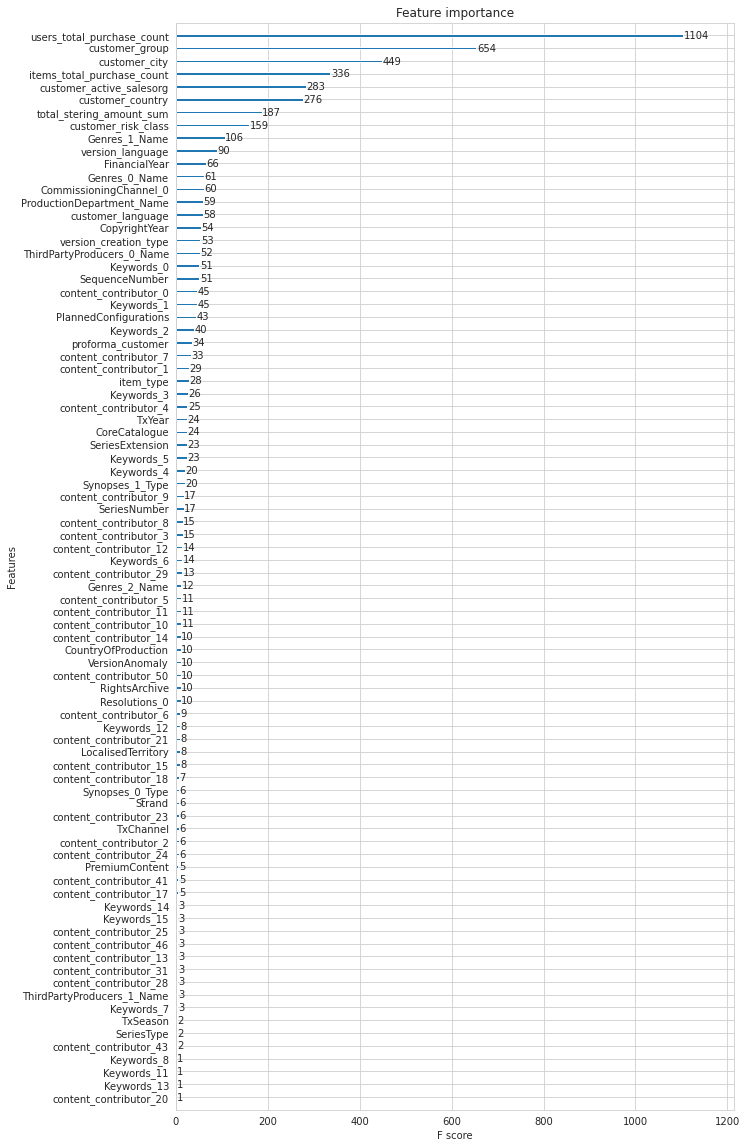

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(xgb_clf, ax=ax)
plt.show()

### 6.1.4 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


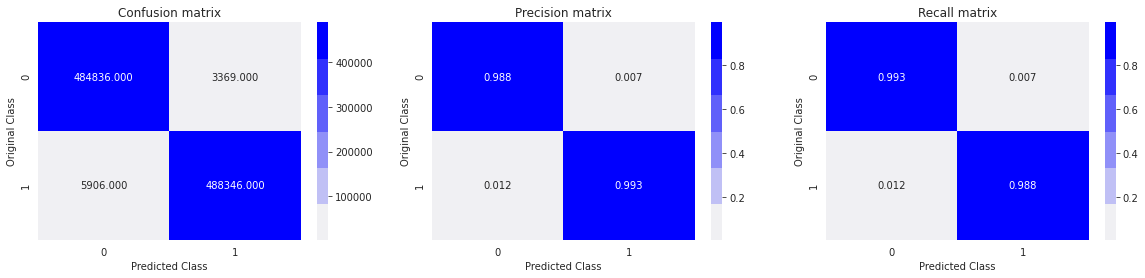

Test confusion_matrix


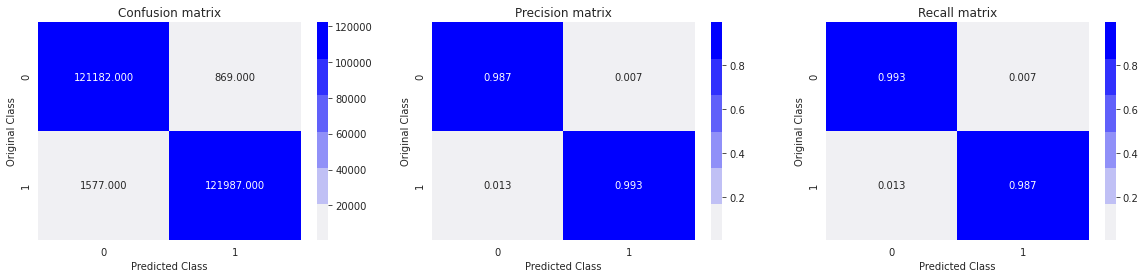

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

#7. Productionisation

In [ ]:
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')
all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)
all_episodeVersions_with_series_data.head()

item_id  LocalisedTerritory  ...  item_type  items_total_purchase_count
0   315383                  15  ...          0                1.828315e-07
1   315384                  15  ...          0                1.828315e-07
2   172845                  15  ...          0                1.828315e-07
3   172844                  15  ...          0                1.828315e-07
4   172816                  15  ...          0                1.828315e-07

[5 rows x 122 columns]

In [ ]:
def prepre_production_support_files_pipeline():
    train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

    train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
    test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)
    all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)
    all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)


    print('Concetenate two dataframes train and test')
    production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
    print(production_data.shape)
    production_data.head()

    print('save "user_item_class_label_data" to csv file')
    production_data[['user_id', 'item_id', 'items_total_purchase_count', 'version_language', 'OriginalLanguage', 'Genres_0_Name',	'Genres_1_Name', 'customer_country', 'customer_group', 'customer_language', 'class_label']].to_csv(drive_path+'/production_data/user_item_class_label_data.csv',index=False)

    print('load the saved "user_item_class_label_data" file for further processing')
    user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')
    print(user_item_class_label_data.shape)

    print('SeriesCollection to Title Mapping')
    seriesCollection = pd.read_csv(drive_path+'/raw_data/seriesCollection.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    seriesCollection.dropna(inplace=True)
    seriesCollection.RecordID = seriesCollection.RecordID.astype(int)
    seriesCollection_to_title_map = {i[0]:i[1] for i in seriesCollection.values}

    print('save seriesCollection_to_title_map')
    pd.to_pickle(seriesCollection_to_title_map, drive_path+'/production_data/seriesCollection_to_title_map.pkl')

    print('EpisodeVersion to Title Mapping')
    episodeVersion = pd.read_csv(drive_path+'/raw_data/episodeVersion.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    episodeVersion.dropna(inplace=True)
    episodeVersion.RecordID = episodeVersion.RecordID.astype(int)
    episodeVersion_to_title_map = {i[0]:i[1] for i in episodeVersion.values}
    
    print('save episodeVersion_to_title_map')
    pd.to_pickle(episodeVersion_to_title_map, drive_path+'/production_data/episodeVersion_to_title_map.pkl')

    print('Version_Language to Encode Value Mapping')
    version_creation_type_language = pd.read_csv(drive_path+'/raw_data/version_creation_type_language.csv')
    ver_df = version_creation_type_language[['_id', 'version_language']].merge(user_item_class_label_data[['item_id', 'version_language']], left_on='_id', right_on='item_id')
    ver_lang_to_encode_map = {ver_lang:encode_value for (ver_lang, encode_value) in set(zip(ver_df.version_language_x.values, ver_df.version_language_y.values))}
    ver_lang_to_encode_map['<unknown>'] = len(ver_lang_to_encode_map)+1
    pd.to_pickle(ver_lang_to_encode_map, drive_path+'/production_data/ver_lang_to_encode_map.pkl')
    encode_value_to_ver_lang_map = {encode: ver_lang for ver_lang, encode in ver_lang_to_encode_map.items()} 


    print('User to Name Mapping')
    customer_df = pd.read_csv(drive_path+'/raw_data/customer_data.csv', sep=',', encoding='ISO-8859-1')
    cust_df = customer_df.merge(user_item_class_label_data, on='user_id')
    customer_to_name_map = {user_id:user_name for (user_id, user_name) in set(zip(cust_df.user_id, cust_df.contact_name))}
    pd.to_pickle(customer_to_name_map, drive_path+'/production_data/customer_to_name_map.pkl')

    print('Customer Language to Encoded Value Mapping')
    customer_language_to_encode_value_map = {customer_language:encode_value for (customer_language, encode_value) in set(zip(cust_df.customer_language_x.values, cust_df.customer_language_y.values))}
    pd.to_pickle(customer_language_to_encode_value_map, drive_path+'/production_data/customer_language_to_encode_value_map.pkl')
    encode_value_to_customer_language_map = {encode:lang for lang, encode in customer_language_to_encode_value_map.items()}


    print('Country to Encoded Value Mapping')
    country_to_encoded_value_map = {country: encoded_value for (country, encoded_value) in set(zip(cust_df.customer_country_x.values, cust_df.customer_country_y.values))}
    
    print('save country_to_encoded_value_map')
    pd.to_pickle(country_to_encoded_value_map, drive_path+'/production_data/country_to_encoded_value_map.pkl')
    encode_value_to_country_map = {encode:country for country, encode in country_to_encoded_value_map.items()}

    print('Genre to Encoded Value Mapping')
    all_deals_with_series_id = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv', usecols=['item_id','series_id'])
    rl_series_data = pd.read_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', usecols=['_id', 'Genres_0_Name','Genres_1_Name']) 
    gc = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id').merge(user_item_class_label_data[['item_id','Genres_0_Name','Genres_1_Name']], on='item_id')
    genre_to_encoded_value_map = {genre:encoded_value for (genre, encoded_value) in set(zip(gc['Genres_0_Name_x'].values, gc['Genres_0_Name_y'].values))}
    
    print('save genre_to_encoded_value_map')
    pd.to_pickle(genre_to_encoded_value_map, drive_path+'/production_data/genre_to_encoded_value_map.pkl')
    sub_genre_to_encoded_value_map = {sub_genre:encoded_value for (sub_genre, encoded_value) in set(zip(gc['Genres_1_Name_x'].values, gc['Genres_1_Name_y'].values))}
    
    print('save sub_genre_to_encoded_value_map')
    pd.to_pickle(sub_genre_to_encoded_value_map, drive_path+'/production_data/sub_genre_to_encoded_value_map.pkl')

    print('Content Type to Encoded Value Mapping')
    item_type_to_encoded_value_map = {'Episode Version': 0, 'Format': 1, 'Series Collection': 2}
    
    print('save item_type_to_encoded_value_map')
    pd.to_pickle(item_type_to_encoded_value_map, drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

    print('User Lookup Data')
    user_features = ['user_id', 'users_total_purchase_count', 'customer_group', 'customer_city', 'customer_country', 'customer_active_salesorg', 'proforma_customer', 'customer_language', 'customer_risk_class']
    user_lookup_data = production_data.copy()[user_features]
    print('Before dropping duplicates: ', user_lookup_data.shape)
    user_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', user_lookup_data.shape)
    
    print('save "user_lookup_data" to csv file')
    user_lookup_data.to_csv(drive_path+'/production_data/user_lookup_data.csv',index=False)
    print('reduce the memory size of user_lookup_data')
    user_lookup_data, _ = reduce_mem_usage(user_lookup_data)
    print('save "user_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(user_lookup_data),drive_path+'/production_data/user_lookup_data_dtypes.pkl')

    print('Item Lookup Data')
    item_lookup_data = production_data.copy().drop(user_features+['total_stering_amount_sum', 'class_label'],axis=1)
    print('Before dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.head()
    print('save "item_lookup_data" to csv file')
    item_lookup_data.to_csv(drive_path+'/production_data/item_lookup_data.csv',index=False)
    print('reduce the memory size of item_lookup_data')
    item_lookup_data, _ = reduce_mem_usage(item_lookup_data)
    print('save "item_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(item_lookup_data),drive_path+'/production_data/item_lookup_data_dtypes.pkl')

    print("SeriesCollection Lookup Data")
    all_seriesCollections_with_series_data = all_seriesCollections_with_series_data[all_seriesCollections_with_series_data.item_id.isin(seriesCollection_to_title_map.keys())]
    print(all_seriesCollections_with_series_data.shape)
    print('save "all_seriesCollections_with_series_data" to csv file')
    all_seriesCollections_with_series_data.to_csv(drive_path+'/production_data/all_seriesCollections_with_series_data.csv',index=False)

    print("EpisodeVersion Lookup Data")
    all_episodeVersions_with_series_data = all_episodeVersions_with_series_data[all_episodeVersions_with_series_data.item_id.isin(episodeVersion_to_title_map.keys())]
    print(all_episodeVersions_with_series_data.shape)
    print('save "all_episodeVersions_with_series_data" to csv file')
    all_episodeVersions_with_series_data.to_csv(drive_path+'/production_data/all_episodeVersions_with_series_data.csv',index=False)

prepre_production_support_files_pipeline()

Concetenate two dataframes train and test
(617816, 134)
save "user_item_class_label_data" to csv file
load the saved "user_item_class_label_data" file for further processing
(617816, 11)
SeriesCollection to Title Mapping
save seriesCollection_to_title_map
EpisodeVersion to Title Mapping
save episodeVersion_to_title_map
Version_Language to Encode Value Mapping
User to Name Mapping
Customer Language to Encoded Value Mapping
Country to Encoded Value Mapping
save country_to_encoded_value_map
Genre to Encoded Value Mapping
save genre_to_encoded_value_map
save sub_genre_to_encoded_value_map
Content Type to Encoded Value Mapping
save item_type_to_encoded_value_map
User Lookup Data
Before dropping duplicates:  (617816, 9)
After dropping duplicates:  (1497, 9)
save "user_lookup_data" to csv file
reduce the memory size of user_lookup_data
Memory usage of properties dataframe is : 0.035691261291503906  MB
******************************
Column:  user_id
dtype before:  uint32
dtype after:  uint32
*

## 7.1 Prepare dataframes for production

###7.1.0 Concetenate two dataframes train and test

In [ ]:
production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
print(production_data.shape)
production_data.head()

(617816, 133)


user_id  item_id  ...  customer_language  customer_risk_class
866210  1112391   172904  ...                  1                    2
81300   1112952   192126  ...                  1                    1
597470  1112746   169674  ...                  1                    1
296803  1112890   188077  ...                  1                    2
973885  1111456   312028  ...                  1                    2

[5 rows x 133 columns]

In [ ]:
# save "production_data" to csv file
#production_data.to_csv(drive_path+'production_data.csv',index=False)

In [ ]:
# load the saved "production_data" file for further processing
# production_data = pd.read_csv(drive_path+'production_data.csv')
# print(production_data.shape)
# production_data.head()


In [ ]:
# save "user_item_class_label_data" to csv file
production_data[['user_id', 'item_id', 'items_total_purchase_count', 'version_language', 'OriginalLanguage', 'Genres_0_Name',	'Genres_1_Name', 'customer_country', 'customer_group', 'customer_language', 'class_label']].to_csv(drive_path+'/production_data/user_item_class_label_data.csv',index=False)

In [ ]:
# load the saved "user_item_class_label_data" file for further processing
user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')
print(user_item_class_label_data.shape)
user_item_class_label_data.head()

(617816, 11)


user_id  item_id  ...  customer_language  class_label
0  1112391   172904  ...                  1            1
1  1112952   192126  ...                  1            1
2  1112746   169674  ...                  1            1
3  1112890   188077  ...                  1            1
4  1111456   312028  ...                  1            1

[5 rows x 11 columns]

###7.1.2 SeriesCollection to Title Mapping

In [ ]:
from tqdm import tqdm
seriesCollection = pd.read_csv(drive_path+'/raw_data/seriesCollection.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
seriesCollection.dropna(inplace=True)
seriesCollection.RecordID = seriesCollection.RecordID.astype(int)
seriesCollection_to_title_map = {i[0]:i[1] for i in seriesCollection.values}

#save seriesCollection_to_title_map
pd.to_pickle(seriesCollection_to_title_map, drive_path+'/production_data/seriesCollection_to_title_map.pkl')

In [ ]:
# load seriesCollection_to_title_map
seriesCollection_to_title_map = pd.read_pickle(drive_path+'/production_data/seriesCollection_to_title_map.pkl')

###7.1.3 EpisodeVersion to Title Mapping

In [ ]:
episodeVersion = pd.read_csv(drive_path+'/raw_data/episodeVersion.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
episodeVersion.dropna(inplace=True)
episodeVersion.RecordID = episodeVersion.RecordID.astype(int)
episodeVersion_to_title_map = {i[0]:i[1] for i in episodeVersion.values}

#save episodeVersion_to_title_map
pd.to_pickle(episodeVersion_to_title_map, drive_path+'/production_data/episodeVersion_to_title_map.pkl')

In [ ]:
# load episodeVersion_to_title_map
episodeVersion_to_title_map = pd.read_pickle(drive_path+'/production_data/episodeVersion_to_title_map.pkl')

###7.1.3 Version_Language to Encode Value Mapping

In [ ]:
version_creation_type_language = pd.read_csv(drive_path+'/raw_data/version_creation_type_language.csv')
ver_df = version_creation_type_language[['_id', 'version_language']].merge(user_item_class_label_data[['item_id', 'version_language']], left_on='_id', right_on='item_id')
ver_df.head()

_id version_language_x  item_id  version_language_y
0  323764            English   323764                   4
1  323764            English   323764                   4
2  323764            English   323764                   4
3  323764            English   323764                   4
4  323764            English   323764                   4

In [ ]:
ver_lang_to_encode_map = {ver_lang:encode_value for (ver_lang, encode_value) in set(zip(ver_df.version_language_x.values, ver_df.version_language_y.values))}
ver_lang_to_encode_map['<unknown>'] = len(ver_lang_to_encode_map)+1
pd.to_pickle(ver_lang_to_encode_map, drive_path+'/production_data/ver_lang_to_encode_map.pkl')

In [ ]:
encode_value_to_ver_lang_map = {encode: ver_lang for ver_lang, encode in ver_lang_to_encode_map.items()} 


###7.1.3 User to Name Mapping

In [ ]:
customer_df = pd.read_csv(drive_path+'/raw_data/customer_data.csv', sep=',', encoding='ISO-8859-1')
cust_df = customer_df.merge(user_item_class_label_data, on='user_id')
cust_df.head()

user_id  ... class_label
0  1113988  ...           1
1  1113988  ...           1
2  1113988  ...           1
3  1113988  ...           1
4  1113988  ...           1

[5 rows x 20 columns]

In [ ]:
customer_to_name_map = {user_id:user_name for (user_id, user_name) in set(zip(cust_df.user_id, cust_df.contact_name))}
pd.to_pickle(customer_to_name_map, drive_path+'/production_data/customer_to_name_map.pkl')

In [ ]:
# load customer_to_name_map
customer_to_name_map = pd.read_pickle(drive_path+'/production_data/customer_to_name_map.pkl')

### 7.1.4 Customer Language to Encoded Value Mapping

In [ ]:
customer_language_to_encode_value_map = {customer_language:encode_value for (customer_language, encode_value) in set(zip(cust_df.customer_language_x.values, cust_df.customer_language_y.values))}
pd.to_pickle(customer_language_to_encode_value_map, drive_path+'/production_data/customer_language_to_encode_value_map.pkl')

In [ ]:
# load customer_language_to_encode_value_map
customer_language_to_encode_value_map = pd.read_pickle(drive_path+'/production_data/customer_language_to_encode_value_map.pkl')

In [ ]:
encode_value_to_customer_language_map = {encode:lang for lang, encode in customer_language_to_encode_value_map.items()}


### 7.1.4 Country to Encoded Value Mapping

In [ ]:
country_to_encoded_value_map = {country: encoded_value for (country, encoded_value) in set(zip(cust_df.customer_country_x.values, cust_df.customer_country_y.values))}
#save country_to_encoded_value_map
pd.to_pickle(country_to_encoded_value_map, drive_path+'/production_data/country_to_encoded_value_map.pkl')

In [ ]:
# load country_to_encoded_value_map
country_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/country_to_encoded_value_map.pkl')

In [ ]:
encode_value_to_country_map = {encode:country for country, encode in country_to_encoded_value_map.items()}

### 7.1.5 Genre to Encoded Value Mapping

In [ ]:
all_deals_with_series_id = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv', usecols=['item_id','series_id'])
rl_series_data = pd.read_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', usecols=['_id', 'Genres_0_Name','Genres_1_Name']) 

gc = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id').merge(user_item_class_label_data[['item_id','Genres_0_Name','Genres_1_Name']], on='item_id')
gc.head()

item_id  series_id  ...  Genres_0_Name_y Genres_1_Name_y
0   163917       6222  ...                7              14
1   163917       6222  ...                7              14
2   163917       6222  ...                7              14
3   163917       6222  ...                7              14
4   163917       6222  ...                7              14

[5 rows x 7 columns]

In [ ]:
genre_to_encoded_value_map = {genre:encoded_value for (genre, encoded_value) in set(zip(gc['Genres_0_Name_x'].values, gc['Genres_0_Name_y'].values))}
#save genre_to_encoded_value_map
pd.to_pickle(genre_to_encoded_value_map, drive_path+'/production_data/genre_to_encoded_value_map.pkl')

In [ ]:
# load genre_to_encoded_value_map
genre_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/genre_to_encoded_value_map.pkl')

In [ ]:
sub_genre_to_encoded_value_map = {sub_genre:encoded_value for (sub_genre, encoded_value) in set(zip(gc['Genres_1_Name_x'].values, gc['Genres_1_Name_y'].values))}
#save sub_genre_to_encoded_value_map
pd.to_pickle(sub_genre_to_encoded_value_map, drive_path+'/production_data/sub_genre_to_encoded_value_map.pkl')

In [ ]:
# load sub_genre_to_encoded_value_map
sub_genre_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/sub_genre_to_encoded_value_map.pkl')

### 7.1.6 Content Type to Encoded Value Mapping

In [ ]:
item_type_to_encoded_value_map = {'Episode Version': 0, 'Format': 1, 'Series Collection': 2}
#save item_type_to_encoded_value_map
pd.to_pickle(item_type_to_encoded_value_map, drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

In [ ]:
# load item_type_to_encoded_value_map
item_type_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

### 7.1.7 User Lookup Data

In [ ]:
user_features = ['user_id', 'users_total_purchase_count', 'customer_group', 'customer_city', 'customer_country', 'customer_active_salesorg', 'proforma_customer', 'customer_language', 'customer_risk_class']
user_lookup_data = production_data.copy()[user_features]
print('Before dropping duplicates: ', user_lookup_data.shape)
user_lookup_data.drop_duplicates(inplace=True)
print('After dropping duplicates: ', user_lookup_data.shape)
user_lookup_data.head()

Before dropping duplicates:  (617816, 9)
After dropping duplicates:  (1497, 9)


user_id  ...  customer_risk_class
866210  1112391  ...                    2
81300   1112952  ...                    1
597470  1112746  ...                    1
296803  1112890  ...                    2
973885  1111456  ...                    2

[5 rows x 9 columns]

In [ ]:
# save "user_lookup_data" to csv file
user_lookup_data.to_csv(drive_path+'/production_data/user_lookup_data.csv',index=False)

In [ ]:
# reduce the memory size of user_lookup_data
user_lookup_data, _ = reduce_mem_usage(user_lookup_data)
# save "user_lookup_data" dtypes to pkl file
pd.to_pickle(get_dtypes(user_lookup_data),drive_path+'/production_data/user_lookup_data_dtypes.pkl')

Memory usage of properties dataframe is : 0.035691261291503906  MB
******************************
Column:  user_id
dtype before:  uint32
dtype after:  uint32
******************************
******************************
Column:  users_total_purchase_count
dtype before:  float32
dtype after:  float32
******************************
******************************
Column:  customer_group
dtype before:  uint16
dtype after:  uint16
******************************
******************************
Column:  customer_city
dtype before:  uint16
dtype after:  uint16
******************************
******************************
Column:  customer_country
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  customer_active_salesorg
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  proforma_customer
dtype before:  uint8
dtype after:  uint8
******************************
***************

In [ ]:
# load the saved "user_lookup_data" file for further processing 
user_lookup_data_dtypes = pd.read_pickle(drive_path+'/production_data/user_lookup_data_dtypes.pkl')
user_lookup_data = pd.read_csv(drive_path+'/production_data/user_lookup_data.csv', dtype=user_lookup_data_dtypes)
print(user_lookup_data.shape)
user_lookup_data.head()

(1497, 9)


user_id  users_total_purchase_count  ...  customer_language  customer_risk_class
0  1112476                    1.019306  ...                  1                    2
1  1114925                   -0.505564  ...                  1                    1
2  1112449                   -0.891797  ...                  1                    2
3  1111510                   -0.294264  ...                  1                    2
4  1113236                   -0.501802  ...                  3                    0

[5 rows x 9 columns]

### 7.1.8 Item Lookup Data

In [ ]:
item_lookup_data = production_data.copy().drop(user_features+['total_stering_amount_sum', 'class_label'],axis=1)
print('Before dropping duplicates: ', item_lookup_data.shape)
item_lookup_data.drop_duplicates(inplace=True)
print('After dropping duplicates: ', item_lookup_data.shape)
item_lookup_data.head()

Before dropping duplicates:  (617816, 122)
After dropping duplicates:  (66212, 122)


item_id  item_type  ...  content_contributor_49  content_contributor_50
866210   172904          0  ...                      26                      24
81300    192126          0  ...                      26                      24
597470   169674          0  ...                      26                      24
296803   188077          0  ...                      26                      24
973885   312028          0  ...                      26                      24

[5 rows x 122 columns]

In [ ]:
# save "item_lookup_data" to csv file
item_lookup_data.to_csv(drive_path+'/production_data/item_lookup_data.csv',index=False)

In [ ]:
# reduce the memory size of item_lookup_data
item_lookup_data, _ = reduce_mem_usage(item_lookup_data)
# save "item_lookup_data" dtypes to pkl file
pd.to_pickle(get_dtypes(item_lookup_data),drive_path+'/production_data/item_lookup_data_dtypes.pkl')

Memory usage of properties dataframe is : 12.250068664550781  MB
******************************
Column:  item_id
dtype before:  uint32
dtype after:  uint32
******************************
******************************
Column:  item_type
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  items_total_purchase_count
dtype before:  float32
dtype after:  float32
******************************
******************************
Column:  version_creation_type
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  version_language
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  LocalisedTerritory
dtype before:  uint8
dtype after:  uint8
******************************
******************************
Column:  SeriesNumber
dtype before:  uint8
dtype after:  uint8
******************************
*****************************

In [ ]:
# load the saved "item_lookup_data" file for further processing 
item_lookup_data_dtypes = pd.read_pickle(drive_path+'/production_data/item_lookup_data_dtypes.pkl')
item_lookup_data = pd.read_csv(drive_path+'/production_data/item_lookup_data.csv', dtype=item_lookup_data_dtypes)
print(item_lookup_data.shape)
item_lookup_data.head()

(66212, 122)


item_id  item_type  ...  content_contributor_49  content_contributor_50
0   240835          0  ...                      26                      24
1   172633          0  ...                      26                      24
2   192610          0  ...                      26                      24
3   357647          0  ...                      26                      24
4   173067          0  ...                      26                      24

[5 rows x 122 columns]

### 7.1.8 SeriesCollection Lookup Data

In [ ]:
# load the saved "all_seriesCollections_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv")
all_seriesCollections_with_series_data = all_seriesCollections_with_series_data[all_seriesCollections_with_series_data.item_id.isin(seriesCollection_to_title_map.keys())]

print(all_seriesCollections_with_series_data.shape)
all_seriesCollections_with_series_data.head()

(25440, 122)


item_id  LocalisedTerritory  ...  item_type  items_total_purchase_count
0   328252                  15  ...          2                2.023732e-07
1   322254                  15  ...          2                2.023732e-07
2   330758                  15  ...          2                2.023732e-07
3   330773                  15  ...          2                2.023732e-07
4   355343                  15  ...          2                2.023732e-07

[5 rows x 122 columns]

In [ ]:
version_creation_type_language = pd.read_csv(drive_path+'/raw_data/version_creation_type_language.csv')

version_creation_type_encode = version_creation_type_language.merge(all_seriesCollections_with_series_data[['item_id','version_creation_type']],left_on='_id',right_on='item_id')

set(zip(version_creation_type_encode['version_creation_type_y'], version_creation_type_encode['version_creation_type_x']))

{(0, 'Broadcast'),
 (1, 'Co-producer'),
 (2, 'Edit'),
 (3, 'Language Dub'),
 (4, 'Worldwide')}

In [ ]:
# save "all_seriesCollections_with_series_data" to csv file
all_seriesCollections_with_series_data.to_csv(drive_path+'/production_data/all_seriesCollections_with_series_data.csv',index=False)

In [ ]:
# load the saved "all_seriesCollections_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/production_data/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)

print(all_seriesCollections_with_series_data.shape)
all_seriesCollections_with_series_data.head()

(28597, 122)


item_id  item_type  ...  content_contributor_49  content_contributor_50
0   323730          2  ...                      26                      24
1   326149          2  ...                      26                      24
2   337192          2  ...                      26                      24
3   337193          2  ...                      26                      24
4   326860          2  ...                      26                      24

[5 rows x 122 columns]

### 7.1.8 EpisodeVersion Lookup Data

In [ ]:
# load the saved "all_episodeVersions_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)[item_lookup_data.columns]
all_episodeVersions_with_series_data = all_episodeVersions_with_series_data[all_episodeVersions_with_series_data.item_id.isin(episodeVersion_to_title_map.keys())]

print(all_episodeVersions_with_series_data.shape)
all_episodeVersions_with_series_data.head()

(142384, 122)


item_id  item_type  ...  content_contributor_49  content_contributor_50
0   173738          0  ...                      17                      16
1   174918          0  ...                      17                      16
2   174894          0  ...                      17                      16
3   174896          0  ...                      17                      16
4   174904          0  ...                      17                      16

[5 rows x 122 columns]

In [ ]:
# save "all_episodeVersions_with_series_data" to csv file
all_episodeVersions_with_series_data.to_csv(drive_path+'/production_data/all_episodeVersions_with_series_data.csv',index=False)

In [ ]:
# load the saved "all_episodeVersions_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/production_data/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)

print(all_episodeVersions_with_series_data.shape)
all_episodeVersions_with_series_data.head()

(153287, 122)


item_id  item_type  ...  content_contributor_49  content_contributor_50
0   206896          0  ...                      26                      24
1   206908          0  ...                      26                      24
2   206902          0  ...                      26                      24
3   206910          0  ...                      26                      24
4   206898          0  ...                      26                      24

[5 rows x 122 columns]

## 7.2 Create Sparse matrix for whole data

In [ ]:
# creating sparse matrix for seriesCollection & episodeVersion

def create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map):

  user_item_interaction_sparse_matrix = {}

  for content, data in {'Series Collection': seriesCollection_to_title_map, 'Episode Version': episodeVersion_to_title_map}.items():
    user_index_map = {user: idx for idx, user in enumerate(user_item_class_label_data.user_id.unique())}
    item_index_map = {item: idx for idx, item in enumerate(data.keys())}

    user_item_interaction_sparse_matrix[content] = csr_matrix((len(user_index_map), len(item_index_map)), dtype=np.uint8)

    content_ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]

    content_data = user_item_class_label_data[user_item_class_label_data.item_id.isin(content_ids)]

    user_item_interacted_data = list(zip(content_data.user_id.values, content_data.item_id.values))

    for (user, item) in tqdm(user_item_interacted_data):
      row = user_index_map[user]
      col = item_index_map[item]
      user_item_interaction_sparse_matrix[content][row, col]=1

  return user_item_interaction_sparse_matrix

#user_item_interaction_sparse_matrix = create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map)

In [ ]:
# save "user_item_interaction_sparse_matrix" to pkl file
pd.to_pickle(user_item_interaction_sparse_matrix, drive_path+"/production_data/user_item_interaction_sparse_matrix.pkl")

In [ ]:
# load the saved "user_item_interaction_sparse_matrix" file for further processing 
user_item_interaction_sparse_matrix = pd.read_pickle(drive_path+"/production_data/user_item_interaction_sparse_matrix.pkl")
user_item_interaction_sparse_matrix['Series Collection'].shape, user_item_interaction_sparse_matrix['Episode Version'].shape

((1497, 28578), (1497, 153264))

##7.2 Compute User-User Similarity matrix

In [ ]:
# save user_contributor_interaction_sparse_matrix
user_genre_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

def create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix):
  start = datetime.now()
  c_c_sim_sparse = cosine_similarity(X=user_genre_contributor_interaction_sparse_matrix, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/production_data/c_c_sim_sparse.npz", c_c_sim_sparse)

  print("It's a ",c_c_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return c_c_sim_sparse

#c_c_sim_sparse = create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix)

###7.2.1 Create recommendation function for new Item

In [ ]:
from collections import Counter
from collections import OrderedDict
from tqdm import tqdm

# load user_index_map
user_index_map = pd.read_pickle(drive_path+'/production_data/user_index_map.pkl')
index_user_map = {idx: user for user, idx in user_index_map.items()}

# save contrib_index_map
contrib_index_map = pd.read_pickle(drive_path+'/production_data/contrib_index_map.pkl')
index_contrib_map = {idx: contrib for contrib, idx in contrib_index_map.items()}

# load user_contributor_interaction_sparse_matrix
user_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

def recommend_new_item_to_users(index_user_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data):

  contrib_wise_user = {}

  for contrib, idx in contrib_index_map.items():
      contrib_wise_user[contrib] = [index_user_map[i] for i in (~user_contributor_interaction_sparse_matrix[idx,:].toarray()).argsort().flatten()]

  top_users = 10
  top_users_per_genre_and_contrib = {}
  top_simillar_users_per_genre_and_contrib = {}

  for key, val in tqdm(contrib_wise_user.items()):
      all_items = []
      similarities = c_c_sim_sparse[contrib_index_map[key]].toarray().ravel()
      top_10_contribs = [index_contrib_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
      for contrib in top_10_contribs:
        top_10_indices = contrib_wise_user[contrib][:top_users]
        all_items.extend(top_10_indices)

      d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
      top_simillar_users_per_genre_and_contrib[key]=np.unique([i for i in production_data[production_data.user_id.isin(list(d_sorted_by_value.keys()))]['user_id'].values])[:top_users]
          
      top_users_per_genre_and_contrib[key]=contrib_wise_user[key][:top_users]
  
  return top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib

#top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib = recommend_new_item_to_users(index_user_map, index_contrib_map, user_genre_contributor_interaction_sparse_matrix, production_data)


In [ ]:
#save top_users_per_genre & top_simillar_users_per_genre files
pd.to_pickle(top_users_per_genre_and_contrib, drive_path+'/production_data/top_users_per_genre_and_contrib.pkl')
pd.to_pickle(top_simillar_users_per_genre_and_contrib, drive_path+'/production_data/top_simillar_users_per_genre_and_contrib.pkl')


## 7.3 Compute Item-Item Similarity matrix

###7.3.1 SeriesCollection-SeriesCollection Similarity matrix

In [ ]:
def create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix):
  start = datetime.now()
  sc_sc_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Series Collection'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/intermittent_saved_files/sc_sc_sim_sparse.npz", sc_sc_sim_sparse)
  print("Done..")

  print("It's a ",sc_sc_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return sc_sc_sim_sparse

#sc_sc_sim_sparse = create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix)

Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (28578, 28578)  dimensional matrix
0:00:01.176864


###7.3. EpisodeVersion-EpisodeVersion Similarity matrix

In [ ]:
def create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix):

  start = datetime.now()
  epv_epv_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Episode Version'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  sparse.save_npz(drive_path+"/intermittent_saved_files/epv_epv_sim_sparse.npz", epv_epv_sim_sparse)
  print("Done..")
  print("It's a ",epv_epv_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return epv_epv_sim_sparse

#epv_epv_sim_sparse = create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix)


###7.3.1 Create recommendation function for new User

In [ ]:
from collections import OrderedDict
from collections import Counter
from tqdm import tqdm

user_country_genre_category_wise_items = { i: production_data[production_data.customer_country==i]['item_id'].value_counts().index for i in production_data['customer_country'].unique()}

user_country_genre_category_wise_items = {}

for country in country_to_encoded_value_map.keys():
  user_country_genre_category_wise_items[country] = {}
  for content, data in {'seriesCollection': seriesCollection_to_title_map, 'episodeVersion': episodeVersion_to_title_map}.items():
    ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]
    data0 = user_item_class_label_data[user_item_class_label_data.item_id.isin(ids)]
    user_country_genre_category_wise_items[country][content] = {}
    for genre in genre_to_encoded_value_map.keys():
      cond1 = data0.customer_country==country_to_encoded_value_map[country]
      cond2 = data0['Genres_0_Name']==genre_to_encoded_value_map[genre]
      user_country_genre_category_wise_items[country][content][genre]=data0[cond1 & cond2]['item_id'].value_counts().index

  sc_to_index_map = {sc: idx for idx, sc in enumerate(seriesCollection_to_title_map.keys())}
  index_to_sc_map = {idx: sc for sc, idx in sc_to_index_map.items()}

  epv_to_index_map = {epv: idx for idx, epv in enumerate(episodeVersion_to_title_map.keys())}
  index_to_epv_map = {idx: epv for epv, idx in epv_to_index_map.items()}

def recommendatation_for_new_user(top_users=10):
  
  top_items_per_user_country_genre_category = {}
  top_simillar_items_per_user_country_genre_category = {}

  for country, content_data in tqdm(user_country_genre_category_wise_items.items()):
    top_items_per_user_country_genre_category[country] = {}
    top_simillar_items_per_user_country_genre_category[country] = {}
    for content, genre_data in content_data.items():
      top_items_per_user_country_genre_category[country][content] = {}
      top_simillar_items_per_user_country_genre_category[country][content] = {}
      for genre, item_data in genre_data.items():
        all_items = []
        for it_id in item_data[:top_users]:
            if content=='seriesCollection':
              similarities = sc_sc_sim_sparse[sc_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_sc_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
            elif content=='episodeVersion':
              similarities = epv_epv_sim_sparse[epv_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_epv_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
        d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
        if content=='seriesCollection':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
        elif content=='episodeVersion':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
    
  return top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category

top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category = recommendatation_for_new_user()

100%|██████████| 92/92 [00:37<00:00,  2.43it/s]


top_items_per_user_country_genre_category['United Kingdom']['episodeVersion']

In [ ]:
#save top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files
pd.to_pickle(top_items_per_user_country_genre_category, drive_path+'/production_data/top_items_per_user_country_genre_category_1.pkl')
pd.to_pickle(top_simillar_items_per_user_country_genre_category, drive_path+'/production_data/top_simillar_items_per_user_country_genre_category_1.pkl')


In [ ]:
#load top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files
top_items_per_user_country_genre_category_ = pd.read_pickle(drive_path+'/production_data/top_items_per_user_country_genre_category.pkl')
top_simillar_items_per_user_country_genre_category_ = pd.read_pickle(drive_path+'/production_data/top_simillar_items_per_user_country_genre_category.pkl')

In [ ]:
top_items_per_user_country_genre_category_['United Kingdom']

{'Episode Version': {"Children's": array(['3rd and Bird: Ep 001: Fly, Muffin! (00:09:29) - Broadcast',
         '3rd and Bird: Ep 002: Bird Theatre (00:09:27) - Broadcast',
         '3rd and Bird: Ep 003: A Chorus for Us (00:09:29) - Broadcast',
         '3rd and Bird: Ep 004: To Play or Not to Play (00:09:29) - Broadcast',
         '3rd and Bird: Ep 005: Muffin Express (00:09:29) - Broadcast',
         '3rd and Bird: Ep 006: The Rudy Show (00:09:29) - Broadcast',
         '3rd and Bird: Ep 007: Superslide! (00:09:29) - Broadcast',
         '3rd and Bird: Ep 008: Costume Party (00:09:29) - Broadcast',
         '3rd and Bird: Ep 009: Meet Elliot! (00:09:29) - Broadcast',
         '3rd and Bird: Ep 010: Pogo Nest (00:09:29) - Broadcast'],
        dtype='<U119'),
  'Documentaries': array(['1945: The Savage Peace (00:57:38) - Broadcast',
         '50 Things to Eat Before You Die (01:00:00) - Worldwide',
         '8 Days: To the Moon and Back (2 eps): Ep 001: Episode 1 (00:49:13) - Worldwid

## 7.4 Recommendation function for existing user & item

In [ ]:
production_columns = list(production_data.columns)
production_columns.remove('class_label')

pd.to_pickle(production_columns, drive_path+'/production_data/production_columns.pkl')

In [ ]:
# load the production columns
production_columns = pd.read_pickle(drive_path+'/production_data/production_columns.pkl')

In [ ]:
sample_user_id = 1112888
#user_item_class_label_data[user_item_class_label_data.user_id==1112888].customer_language.unique()[0]
#user_item_class_label_data[user_item_class_label_data.user_id==1112888]['item_id'].values
#all_seriesCollections_with_series_data[all_seriesCollections_with_series_data.version_language==3].item_id.values

#user_item_class_label_data[(user_item_class_label_data.user_id==sample_user_id)&(user_item_class_label_data.version_language==3)]['item_id'].values

production_data.total_stering_amount_sum.mean()

0.08816955983638763

In [ ]:
#### load_required_files_for_predictions

# load the saved "user_item_class_label_data" file for further processing
user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')

# load seriesCollection_to_title_map
seriesCollection_to_title_map = pd.read_pickle(drive_path+'/production_data/seriesCollection_to_title_map.pkl')

# load episodeVersion_to_title_map
episodeVersion_to_title_map = pd.read_pickle(drive_path+'/production_data/episodeVersion_to_title_map.pkl')

# load ver_lang_to_encode_map
ver_lang_to_encode_map = pd.read_pickle(drive_path+'/production_data/ver_lang_to_encode_map.pkl')
ver_lang_to_encode_map['<unknown>'] = 26

encode_value_to_ver_lang_map = {encode: ver_lang for ver_lang, encode in ver_lang_to_encode_map.items()} 

# load customer_to_name_map
customer_to_name_map = pd.read_pickle(drive_path+'/production_data/customer_to_name_map.pkl')

# load customer_language_to_encode_value_map
customer_language_to_encode_value_map = pd.read_pickle(drive_path+'/production_data/customer_language_to_encode_value_map.pkl')
encode_value_to_customer_language_map = {encode:lang for lang, encode in customer_language_to_encode_value_map.items()}

# load country_to_encoded_value_map
country_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/country_to_encoded_value_map.pkl')
encode_value_to_country_map = {encode:country for country, encode in country_to_encoded_value_map.items()}

# load genre_to_encoded_value_map
genre_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/genre_to_encoded_value_map.pkl')

# load item_type_to_encoded_value_map
item_type_to_encoded_value_map = pd.read_pickle(drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

# load the saved "user_lookup_data" file for further processing 
user_lookup_data_dtypes = pd.read_pickle(drive_path+'/production_data/user_lookup_data_dtypes.pkl')
user_lookup_data = pd.read_csv(drive_path+'/production_data/user_lookup_data.csv', dtype=user_lookup_data_dtypes)

# load the saved "item_lookup_data" file for further processing 
item_lookup_data_dtypes = pd.read_pickle(drive_path+'/production_data/item_lookup_data_dtypes.pkl')
item_lookup_data = pd.read_csv(drive_path+'/production_data/item_lookup_data.csv', dtype=item_lookup_data_dtypes)

# load the saved "all_seriesCollections_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/production_data/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)

# load the saved "all_episodeVersions_with_series_data" file for further processing 
train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/production_data/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)

# load the production columns
production_columns = pd.read_pickle(drive_path+'/production_data/production_columns.pkl')

from xgboost.sklearn import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=800)

version_number = 1.1
filename = '/production_data/xgb_clf_{0}.model'.format(version_number)

# load the model
xgb_clf.load_model(drive_path+filename)

In [ ]:
def make_recommendation_for_existing_user_and_item(sample_user_id, top_items=10):
    #load saved model
    #xgb_clf = joblib.load(drive_path+'xgb_clf')

    recomended_items = {}

    for key, data in {'seriesCollection': all_seriesCollections_with_series_data, 'episodeVersion': all_episodeVersions_with_series_data}.items():

      users, items, = [], []

      customer_language = user_item_class_label_data[user_item_class_label_data.user_id==sample_user_id].customer_language.unique()[0]

      sample_user_prchased_items = user_item_class_label_data[(user_item_class_label_data.user_id==sample_user_id)&(user_item_class_label_data.version_language==customer_language)]['item_id'].values
      sample_user_not_purchased_items = list(set(data[data.version_language==customer_language].item_id.values) - set(sample_user_prchased_items))

      users.extend(np.zeros(len(sample_user_not_purchased_items),dtype=np.uint32)+sample_user_id)
      items.extend(sample_user_not_purchased_items)

      items_not_purchased_by_user_data = pd.DataFrame({'user_id':users,
                                                      'item_id':items, 
                                                      'total_stering_amount_sum':0.08816955983638763,#production_data.total_stering_amount_sum.mean()
                                                      })

      items_not_purchased_by_user_data = items_not_purchased_by_user_data.merge(user_lookup_data, on='user_id').merge(data, on='item_id')[production_columns]

      items_not_purchased_by_user_data['y_pred'] = xgb_clf.predict_proba(items_not_purchased_by_user_data.drop(['user_id','item_id',],axis=1))[:,1]
      
      top_recommended_items = items_not_purchased_by_user_data.sort_values(by='y_pred', ascending=False)[['item_id', 'Genres_0_Name']]

      if key == 'seriesCollection':
        recomended_items[key] = {}
        for genre in genre_to_encoded_value_map.keys():
          recomended_items[key][genre] = np.array([seriesCollection_to_title_map[item] for item in top_recommended_items[top_recommended_items['Genres_0_Name']==genre_to_encoded_value_map[genre]]['item_id'].values[:top_items]])
      elif key == 'episodeVersion':
        recomended_items[key] = {}
        for genre in genre_to_encoded_value_map.keys():
          recomended_items[key][genre] = np.array([episodeVersion_to_title_map[item] for item in top_recommended_items[top_recommended_items['Genres_0_Name']==genre_to_encoded_value_map[genre]]['item_id'].values[:top_items]])

    return recomended_items


In [ ]:
recomended_items = make_recommendation_for_existing_user_and_item(1112888)
print('SeriesCollection Recommendation')
print('='*50)
print(recomended_items['seriesCollection'])
print('='*50)
print('EpisodeVersion Recommendation')
print('='*50)
print(recomended_items['episodeVersion'])


SeriesCollection Recommendation
{'Science & Medicine': array(["Horizon: Now the Chips Are Down (1 x 50') - Language Dub"],
      dtype='<U56'), 'Select': array([], dtype=float64), 'Religion': array([], dtype=float64), 'Music & Arts': array([], dtype=float64), 'Education': array([], dtype=float64), 'Drama': array([], dtype=float64), "Children's": array(["Klumpies (26 x 7') - Language Dub",
       "Spot: Series 001: The Adventures of Spot (13 x 5') - Language Dub",
       "It's Fun to Learn with Spot (8 x 14') - Language Dub",
       "Spot and His Grandparents Go to the Carnival (1 x 30') - Language Dub",
       "Spot's Magical Christmas: Special (1 x 30') - Language Dub",
       "Spot's Musical Adventures (13 x 6') - Language Dub",
       "Spot: Series 002: The Adventures of Spot (13 x 5') - Language Dub",
       "Tweenies: Series 002 (78 x 20') - Language Dub"], dtype='<U69'), 'Documentaries': array(["Great Bake Off, The (Holland): Series 001 (8 x 50') - Worldwide",
       "Great Bake 

## For Pipeline Series Data

In [ ]:
pipeline_df = pd.read_excel(drive_path+'Pipeline-17052021.xlsx', usecols=['Catalogue ID', 'Programme Type'])

series_ids = pipeline_df[pipeline_df['Programme Type']=='Series']['Catalogue ID'].unique()
data0=all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.series_id.isin(series_ids)]

seriesCollection_ids = data0[data0.content_type=='Series Collection']['content_id'].unique()
episodeVersion_ids = data0[data0.content_type=='Episode Version']['content_id'].unique()

# production_data.total_stering_amount_sum.mean()
total_stering_amount_sum = 0.08816955983638763

def make_recommendation_for_pipeline(sample_user_id, seriesCollection_ids, episodeVersion_ids, top_items=10):
    recomended_items = {}

    for content, data in {'seriesCollection': all_seriesCollections_with_series_data, 'episodeVersion': all_episodeVersions_with_series_data}.items():
      users, items, = [], []

      customer_language = user_item_class_label_data[user_item_class_label_data.user_id == sample_user_id].customer_language.unique()[0]

      sample_user_prchased_items = user_item_class_label_data[(user_item_class_label_data.user_id == sample_user_id)]['item_id'].values
      sample_user_not_purchased_items = list(set(data.item_id.values) - set(sample_user_prchased_items))

      users.extend(np.zeros(len(sample_user_not_purchased_items), dtype=np.uint32)+sample_user_id)
      items.extend(sample_user_not_purchased_items)

      items_not_purchased_by_user_data = pd.DataFrame({'user_id': users, 'item_id': items, 'total_stering_amount_sum': total_stering_amount_sum })

      items_not_purchased_by_user_data = items_not_purchased_by_user_data.merge(user_lookup_data, on='user_id').merge(data, on='item_id')[production_columns]
            

      items_not_purchased_by_user_data['y_pred'] = xgb_clf.predict_proba(items_not_purchased_by_user_data.drop(['user_id', 'item_id', ], axis=1))[:, 1]

      top_recommended_items = items_not_purchased_by_user_data.sort_values(by='y_pred', ascending=False)[['item_id', 'Genres_0_Name', 'version_language']]

      if content == 'seriesCollection':
        recomended_items[content] = {}
        
        for genre in genre_to_encoded_value_map.keys():
          recomended_items[content][genre] = (np.array(["{0} ({1})".format(seriesCollection_to_title_map[item],
                            encode_value_to_ver_lang_map[top_recommended_items[top_recommended_items.item_id == item]['version_language'].unique()[0]],) for idx, item in enumerate(top_recommended_items[top_recommended_items['Genres_0_Name'] == genre_to_encoded_value_map[genre]]['item_id'].values[:top_items])]),
                            np.array([seriesCollection_to_title_map[item] for item in top_recommended_items[top_recommended_items.version_language == customer_language]['item_id'].values[:top_items]]))

      elif content == 'episodeVersion':
        recomended_items[content] = {}
        for genre in genre_to_encoded_value_map.keys():
          recomended_items[content][genre] = (np.array(["{0} ({1})".format(episodeVersion_to_title_map[item], encode_value_to_ver_lang_map[top_recommended_items[top_recommended_items.item_id == item]['version_language'].unique()[0]]) for item in top_recommended_items[
                        top_recommended_items['Genres_0_Name'] == genre_to_encoded_value_map[genre]]['item_id'].values[:top_items]]), 
                        np.array([episodeVersion_to_title_map[item] for item in top_recommended_items[top_recommended_items.version_language == customer_language]['item_id'].values[:top_items]]))

    return recomended_items


In [ ]:
#production_data['pred_prob'] = np.round(np.array(pred_prob[:,1])*100,2)
production_data[(production_data.user_id==1111446) & production_data.item_id.isin(episodeVersion_ids) & (production_data.pred_prob>99.00)].sort_values('items_total_purchase_count', ascending=True)


user_id  item_id  ...  customer_risk_class  pred_prob
44259   1111446   318249  ...                    2      100.0
146437  1111446   320101  ...                    2      100.0
564489  1111446   315136  ...                    2      100.0
385229  1111446   315137  ...                    2      100.0
548505  1111446   315139  ...                    2      100.0
...         ...      ...  ...                  ...        ...
525277  1111446   293968  ...                    2      100.0
33116   1111446   275633  ...                    2      100.0
727402  1111446   302840  ...                    2      100.0
352605  1111446   302838  ...                    2      100.0
627071  1111446   302839  ...                    2      100.0

[915 rows x 134 columns]

In [ ]:
content_type_array, genre_type_array, item_data_array = [], [], []
user_id_array, company_array, country_array = [], [], []

from tqdm import tqdm
counter = 0
for uid in tqdm(user_item_class_label_data.user_id.unique()):
        recomended_items = make_recommendation_for_pipeline(uid, seriesCollection_ids, episodeVersion_ids)
        customer_language = encode_value_to_customer_language_map[user_item_class_label_data[user_item_class_label_data.user_id == uid].customer_language.unique()[0]]
        for content_type, genre_data in recomended_items.items():
            for genre_type, items_data in genre_data.items():
                if len(items_data[0])>0:
                    for item_title in items_data[0]:
                        user_id_array.append(uid)
                        company_array.append(customer_to_name_map[uid])
                        country_array.append(encode_value_to_country_map[user_item_class_label_data[user_item_class_label_data.user_id == uid].customer_country.unique()[0]])

                        content_type_array.append(content_type)
                        genre_type_array.append(genre_type)
                        item_data_array.append(item_title)
                if (customer_language != 'EN') and (len(items_data[1])>0):
                    for item_title in items_data[1]:
                            user_id_array.append(uid)
                            company_array.append(customer_to_name_map[uid])
                            country_array.append(encode_value_to_country_map[user_item_class_label_data[user_item_class_label_data.user_id == uid].customer_country.unique()[0]])

                            content_type_array.append(content_type)
                            genre_type_array.append(genre_type)
                            item_data_array.append('{0} ({1})'.format(item_title,customer_language))


100%|██████████| 1497/1497 [2:59:56<00:00,  7.21s/it]


In [ ]:
pd.to_pickle(content_type_array, drive_path+'/production_data/content_type_array.pkl')
pd.to_pickle(genre_type_array, drive_path+'/production_data/genre_type_array.pkl')
pd.to_pickle(item_data_array, drive_path+'/production_data/item_data_array.pkl')
pd.to_pickle(user_id_array, drive_path+'/production_data/user_id_array.pkl')
pd.to_pickle(company_array, drive_path+'/production_data/company_array.pkl')
pd.to_pickle(country_array, drive_path+'/production_data/content_type_array.pkl')


In [ ]:
all_companies_recommendations_export_df = pd.DataFrame({'Compnay Id': user_id_array, 
                                            'Company Name': company_array,
                                            'Country': country_array,
                                            'Content Type': content_type_array,
                                            'Genre': genre_type_array,
                                            'Title': item_data_array})

all_companies_recommendations_export_df.drop(index=all_companies_recommendations_export_df[all_companies_recommendations_export_df.Genre=='Select'].index,inplace=True)

all_companies_recommendations_export_df.to_csv(drive_path+'/production_data/all_companies_recommendations_export_df.csv', index=False)


In [ ]:
all_companies_recommendations_export_df['Company Id'].nunique()


KeyError: ignored

In [ ]:
recomended_items = make_recommendation_for_pipeline(1111446, seriesCollection_ids, episodeVersion_ids)
print('SeriesCollection Recommendation')
print('='*50)
print(recomended_items['seriesCollection'])
print('='*50)
print('EpisodeVersion Recommendation')
print('='*50)
print(recomended_items['episodeVersion'])

SeriesCollection Recommendation
{'Science & Medicine': (array(["Factomania (10 x 50') - Worldwide (English) (0.9999996423721313)",
       "Aliens: The Big Think (1 x 50') - Worldwide (English) (0.9999994039535522)",
       "Isaac Newton: The Last Magician (1 x 50') - Worldwide (English) (0.9999992847442627)",
       "Dara O Briain's Science Club: Series 001 (6 x 50') - Worldwide (English) (0.9999992847442627)",
       "Girl Who Talked to Dolphins, The (1 x 50') - Worldwide (English) (0.9999992847442627)",
       "Big Crash Diet Experiment, The (1 x 50') - Worldwide - Presenterlight (English) (0.9999992847442627)",
       "Horizon: Mission to Mars (1 x 50') - Worldwide (English) (0.9999992847442627)",
       "Horizon: Transit of Venus (1 x 50') - Worldwide (English) (0.9999992847442627)",
       "Horizon: What Is Reality? (1 x 50') - Worldwide (English) (0.9999992847442627)",
       "Horizon: Seeing Stars (1 x 50') - Worldwide (English) (0.9999992847442627)"],
      dtype='<U100'), arra

## 7.5 Recommendation fuction for production deployment

In [ ]:
def make_recommendation(user_id, country, item_id, item_genre):

    country_encode_value = country_to_encoded_value_map[country]
    genre_encode_value = genre_to_encoded_value_map[item_genre]

    if (user_id in user_item_class_label_data.user_id.unique())
      make_recommendation_for_existing_user_and_item(user_id)

    elif not user_id in user_item_class_label_data.user_id.unique():
        print("Recommend top_items_per_user_category")
        print("="*50)
        print(np.array([item_to_title_map[item] for item in top_items_per_user_category[country]]))
        print('')
        print("Recommend top_simillar_items_per_user_category")
        print("="*50)
        print(np.array([item_to_title_map[item] for item in top_simillar_items_per_user_category[country]]))
    
    elif not item_id in production_data.item_id.unique():
        print("Recommend to top_users_per_genre")
        print(np.array([user_to_name_map[user] for user in top_users_per_genre[item_genre]]))
        print("="*50)
        print("Recommend to top_simillar_users_per_genre")
        print(np.array([user_to_name_map[user] for user in top_simillar_users_per_genre[item_genre]]))
    

In [ ]:
min = production_data.users_total_purchase_count.min()
production_data[production_data.users_total_purchase_count==min]['user_id'].unique()

array([1111509, 1079044, 1113146, 1112277, 1114687, 1114115, 1113314,
       1114339, 1115040, 1112891, 1114250, 1114571, 1113124, 1113237,
       1113789, 1114267, 1080215, 1113245, 1114537, 1113686, 1114541,
       1113822, 1112172, 1112191, 1113996, 1079212, 1112222, 1373958,
       1114721, 1114580, 1676070, 1114113, 1113975, 1111510, 1112302,
       1112750, 1113577, 1114891, 1079526, 1083149, 1663773, 1081018,
       1113471, 1113772, 1114401, 1114439, 1113788, 1113378, 1373948,
       1112775, 1113951, 1113025, 1373952, 1113717, 1112655, 1114609,
       1373954, 1112755, 1114829, 1083150, 1079236, 1217729, 1114509,
       1113723, 1362703, 1113601, 1114335, 1113501, 1112322, 1373951,
       1114548, 1113391, 1112410, 1300273, 1112317, 1114856, 1112305,
       1113781, 1373949])

In [ ]:
mean = production_data.users_total_purchase_count.mean()
production_data[production_data.users_total_purchase_count>=mean]['user_id'].unique()

array([1111994, 1112028, 1113121, 1112630, 1112743, 1112527, 1112784,
       1111484, 1112092, 1113353, 1113606, 1112951, 1111460, 1113807,
       1111446, 1112764, 1112349, 1111457, 1111491, 1112832, 1111486,
       1112690, 1113074, 1113088, 1111514, 1113785, 1112433, 1112350,
       1112995, 1112631, 1112668, 1111494, 1112495, 1112397, 1113066,
       1111489, 1111506, 1112020, 1112910, 1114110, 1111481, 1112984,
       1111487, 1112476, 1113586, 1112192, 1112107, 1113069, 1113865,
       1113091, 1111803, 1112756, 1111496, 1112969, 1112261, 1112920,
       1113062, 1111483, 1113134, 1112573, 1112333, 1112826, 1113023,
       1112861, 1111488, 1111472, 1111456, 1112308, 1112399, 1111515,
       1112889, 1111959, 1113068, 1112719, 1111503, 1113004, 1112258])

In [ ]:
make_recommendation(user_id=123, country=100, item_id=1234, item_genre=0)

Recommend top_items_per_user_category
['Luther: Series 003 (2 eps): Ep 002: Episode 2 (01:40:00) - Worldwide'
 "Kirstie's House of Craft (10 x 45') - Worldwide"
 'Sherlock: Series 002: Ep 001: A Scandal in Belgravia (01:30:00) - Language Dub'
 'Wildlife on One: Amazon Assassin - A Wildlife Whodunit (00:29:03) - Broadcast'
 "How to Build a Planet (2 x 50') - Language Dub - Presenterless"
 'Planet Oil: Ep 001: Episode 1 (01:00:00) - Broadcast - Presenterled'
 'Ripper Street: Series 001: Ep 008: What Use Our Work (00:50:00) - Language Dub'
 'Strictly Come Dancing: Series 013: Ep 005: Round 02 Results (00:40:46) - Worldwide'
 'Chris Harris on Cars (8 eps): Ep 005: Episode 5 (00:23:56) - Worldwide'
 'Blankety Blank: Series 004: Ep 008: Episode 8 (00:31:56) - Broadcast']

Recommend top_simillar_items_per_user_category
['Wildlife on One: Amazon Assassin - A Wildlife Whodunit (00:29:03) - Broadcast'
 'Luther: Series 003 (2 eps): Ep 002: Episode 2 (01:40:00) - Worldwide'
 'Sherlock: Series 002:

In [ ]:
make_recommendation(user_id=1111457, country='zz', item_id=1234, item_genre=0)

Recommend to top_users_per_genre
['BBC CBeebies Australia' 'RTE (Radio Telefis Eireann)'
 'BBC Middle East Cbeebies' 'Ceska Televize' 'RTE Package'
 'Knowledge West Corp Bbc Kids'
 'ABC (Australian Broadcasting Corporation)'
 'BBC Asia Cbeebies (BBC Studios Limited)'
 'BBC Poland Cbeebies (BBC Studios Limited)' 'BBC CBeebies Latin America']
Recommend to top_simillar_users_per_genre
['BBC Poland Cbeebies (BBC Studios Limited)'
 'BBC Entertainment Europe (BBC Studios Limited)'
 'BBC South Africa Cbeebies (BBC Studios Limited)'
 'BBC CBeebies Latin America' 'BBC Asia Cbeebies (BBC Studios Limited)'
 'BBC CBeebies Australia' 'BBC MARINE HD'
 'BBC Middle East First BBC WORLDWIDE LTD' 'BBC Middle East Cbeebies'
 'BBC VOD Latin America (BBC Studios Limited) Latin America & US Hispanic)']


In [ ]:
make_recommendation(user_id=1111457, country='zz', item_id=357428, item_genre=0)

array(['Doctors: Series 017: Ep 155: Favourites (00:30:00) - Edit',
       'Doctors: Series 017: Ep 098: In Search of Happiness (00:27:51) - Edit',
       'Ross Kemp: Alive in Alaska (00:48:56) - Broadcast',
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 012: Oregon (00:45:00) - Language Dub',
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 002: Morocco (00:45:00) - Language Dub',
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 003: Panama (00:45:00) - Language Dub',
       "Where the Wild Men Are with Ben Fogle: Series 007 (4 x 45') - Language Dub",
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 010: New Zealand (00:45:00) - Language Dub',
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 005: Sweden (00:45:00) - Language Dub',
       'Where the Wild Men Are with Ben Fogle: Series 007: Ep 008: Iceland (00:45:00) - Language Dub'],
      dtype=object)

In [ ]:
make_recommendation(user_id=1079044, country='zz', item_id=357428, item_genre=0)

array(["Waterhole: Africa's Animal Oasis: Ep 001: Episode 1 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis: Ep 003: Episode 3 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis (3 x 50') - Worldwide - Presenterless",
       "Waterhole: Africa's Animal Oasis: Ep 002: Episode 2 (01:00:00) - Broadcast - Presenterled",
       'Wonderful World of Baby Animals, The: Ep 003: Episode 3 (00:43:51) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 004: Episode 4 (00:43:47) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 002: Episode 2 (00:44:09) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 001: Episode 1 (00:43:45) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 005: Episode 5 (00:44:09) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 006: Episode 6 (00:43:48) - Worldwide'],
      dtype=object)

In [ ]:
make_recommendation(user_id=1112345, country='zz', item_id=357428, item_genre=0)

array(["Waterhole: Africa's Animal Oasis: Ep 003: Episode 3 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis: Ep 001: Episode 1 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis (3 x 50') - Worldwide - Presenterless",
       "Waterhole: Africa's Animal Oasis: Ep 002: Episode 2 (01:00:00) - Broadcast - Presenterled",
       'Wonderful World of Baby Animals, The: Ep 002: Episode 2 (00:44:09) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 004: Episode 4 (00:43:47) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 005: Episode 5 (00:44:09) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 006: Episode 6 (00:43:48) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 001: Episode 1 (00:43:45) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 003: Episode 3 (00:43:51) - Worldwide'],
      dtype=object)

In [ ]:
make_recommendation(user_id=1111994, country='zz', item_id=357428, item_genre=0)

array(['Doctors: Series 017: Ep 155: Favourites (00:30:00) - Edit',
       'Doctors: Series 017: Ep 098: In Search of Happiness (00:27:51) - Edit',
       'Doctors: Series 017: Ep 098: In Search of Happiness (00:30:00) - Broadcast',
       'Doctors: Series 017: Ep 155: Favourites (00:28:04) - Broadcast',
       'Doctors: Series 017: Ep 032: Joint Lock (00:28:06) - Broadcast',
       'Doctors: Series 017: Ep 061: Insignificant (00:27:47) - Broadcast',
       "Doctors: Series 017: Ep 158: He's Making a List He's Checking It Twice (00:27:04) - Broadcast",
       'Doctors: Series 017: Ep 059: The Laughing Gnome (00:27:19) - Broadcast',
       'Doctors: Series 017: Ep 159: From Daddy with Love (00:27:55) - Broadcast',
       'Doctors: Series 017: Ep 060: Blind Spot (00:27:43) - Broadcast'],
      dtype=object)

In [ ]:
make_recommendation(user_id=1113807, country='zz', item_id=357428, item_genre=0)

array(["Waterhole: Africa's Animal Oasis: Ep 002: Episode 2 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis: Ep 003: Episode 3 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis: Ep 001: Episode 1 (01:00:00) - Broadcast - Presenterled",
       "Waterhole: Africa's Animal Oasis (3 x 50') - Worldwide - Presenterless",
       'Wonderful World of Baby Animals, The: Ep 001: Episode 1 (00:43:45) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 002: Episode 2 (00:44:09) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 006: Episode 6 (00:43:48) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 004: Episode 4 (00:43:47) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 003: Episode 3 (00:43:51) - Worldwide',
       'Wonderful World of Baby Animals, The: Ep 005: Episode 5 (00:44:09) - Worldwide'],
      dtype=object)

In [ ]:
production_data = pd.read_csv(drive_path+'production_data.csv')
print(production_data.shape)
production_data.head()

(587945, 283)


user_id  ...                                   user_name
0  1111994  ...  Foxtel Management PTY Ltd Foxtel Lifestyle
1  1111994  ...  Foxtel Management PTY Ltd Foxtel Lifestyle
2  1111994  ...  Foxtel Management PTY Ltd Foxtel Lifestyle
3  1111994  ...  Foxtel Management PTY Ltd Foxtel Lifestyle
4  1111994  ...  Foxtel Management PTY Ltd Foxtel Lifestyle

[5 rows x 283 columns]

In [ ]:
props, NAlist = reduce_mem_usage(df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1264.9574737548828  MB
******************************
Column:  Unnamed: 0
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  country
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  item_type
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  total_stering_amount_sum
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  users_total_purchase_count
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  ite